In [ ]:
!pip install koreanize_matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 23.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
import requests
import koreanize_matplotlib

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 클러스터링 기반 폐업 예측 모델

## EDA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/2025-2/2025 빅콘테스트/data/df_0929_ver_1.csv')

In [ ]:
df.value_counts('end')

,count
end,
2025-08-11,168
2025-08-01,115
2025-07-30,102
2025-08-14,96
2025-07-21,83
...,...
2023-05-04,5
2023-04-18,4
2023-04-17,4


In [ ]:
df['end'] = pd.to_datetime(df['end'])
df.groupby(df["end"].dt.to_period("M")).size()

,0
end,
2023-01,1
2023-03,3
2023-04,8
2023-05,15
2023-08,16
2023-09,18
2023-10,20
2023-11,22
2024-01,13


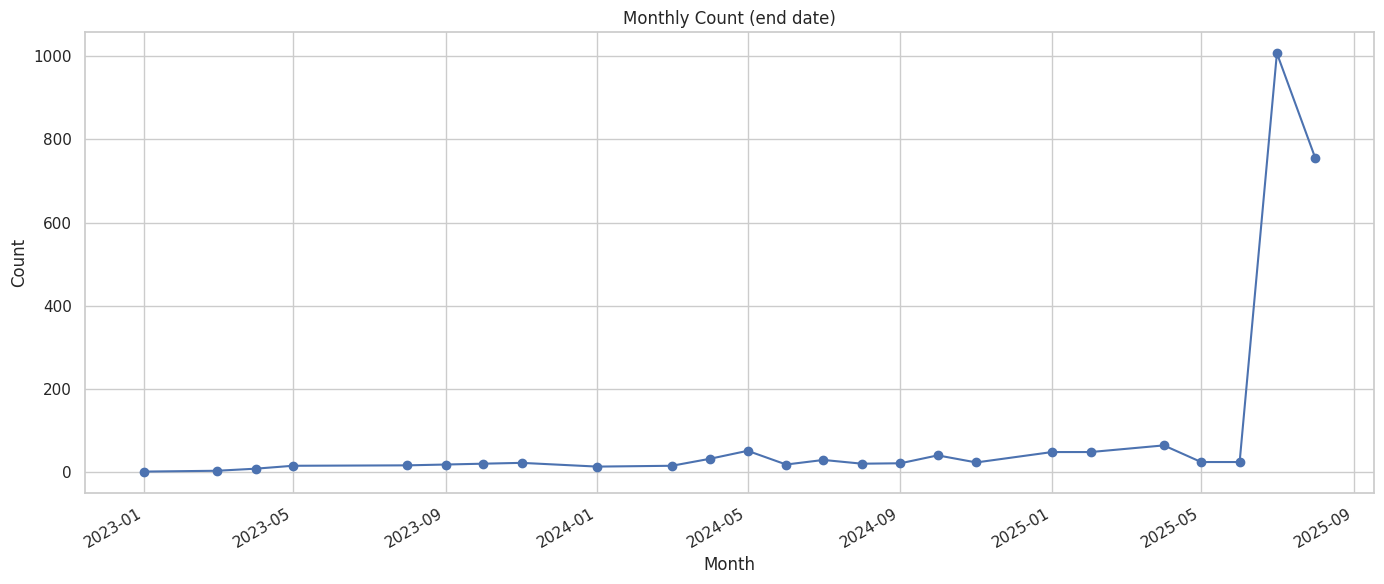

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 2. end 컬럼을 사용한 시각화
df['end'] = pd.to_datetime(df['end'], errors='coerce')

# 월별 집계
end_monthly = df.groupby(df["end"].dt.to_period("M")).size()
end_monthly.index = end_monthly.index.to_timestamp()

# 시각화
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(end_monthly.index, end_monthly.values, marker="o")
ax.set_title("Monthly Count (end date)")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
ax.grid(True)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

## 클러스터링 진행 이유

상권에 따른 거주인구 비율

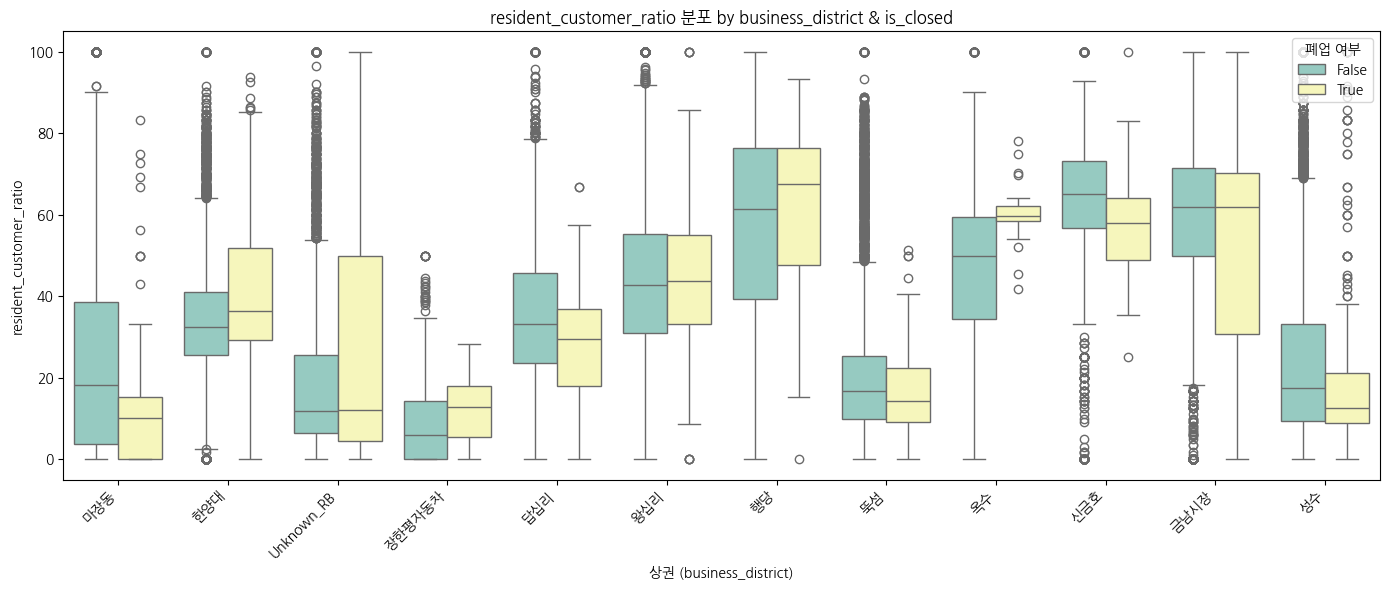

In [ ]:
cols_to_check = ['resident_customer_ratio']

# 폐업 여부 0: 운영, 1: 폐업
df['is_closed'] = df['is_closed'].fillna(0)

for col in cols_to_check:
    plt.figure(figsize=(14,6))
    sns.boxplot(
        data=df,
        x='business_district',
        y=col,
        hue='is_closed',       # 폐업 여부
        palette='Set3'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} 분포 by business_district & is_closed')
    plt.ylabel(col)
    plt.xlabel('상권 (business_district)')
    plt.legend(title='폐업 여부', loc='upper right')
    plt.tight_layout()
    plt.show()


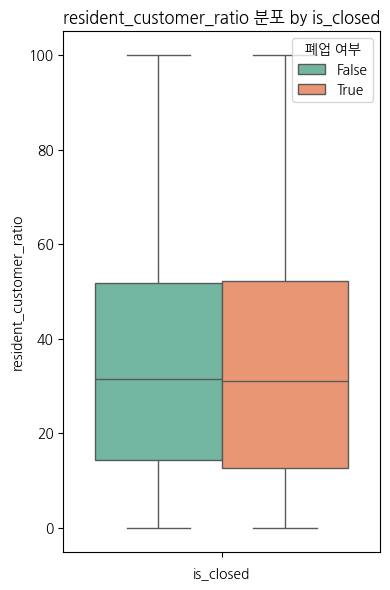

In [ ]:
cols_to_check = ['resident_customer_ratio']

# 폐업 여부 0: 운영, 1: 폐업
df['is_closed'] = df['is_closed'].fillna(0)

for col in cols_to_check:
    plt.figure(figsize=(4,6))
    sns.boxplot(
        data=df,
        y=col,
        hue='is_closed',       # 폐업 여부
        palette='Set2'
    )
    plt.title(f'{col} 분포 by is_closed')
    plt.ylabel(col)
    plt.xlabel('is_closed')
    plt.legend(title='폐업 여부', loc='upper right')
    plt.tight_layout()
    plt.show()

업종에 따른 유동인구 비율

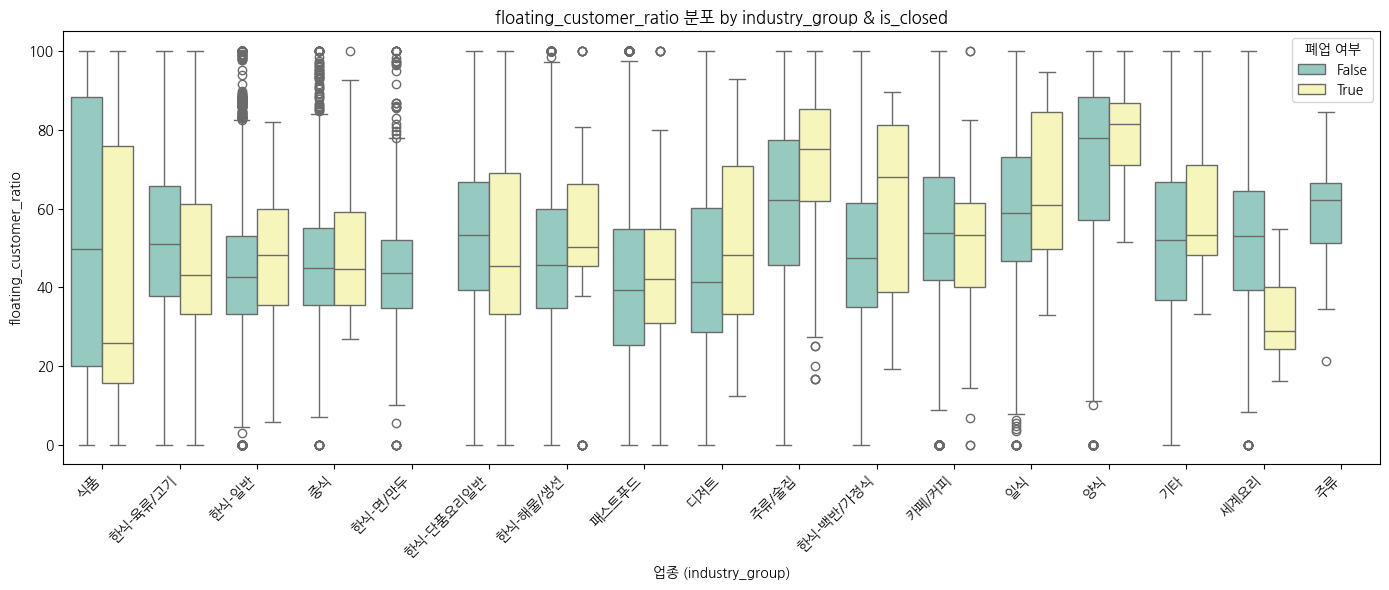

In [ ]:
cols_to_check = ['floating_customer_ratio']

# 폐업 여부 0: 운영, 1: 폐업
df['is_closed'] = df['is_closed'].fillna(0)

for col in cols_to_check:
    plt.figure(figsize=(14,6))
    sns.boxplot(
        data=df,
        x='industry_group',
        y=col,
        hue='is_closed',       # 폐업 여부
        palette='Set3'
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{col} 분포 by industry_group & is_closed')
    plt.ylabel(col)
    plt.xlabel('업종 (industry_group)')
    plt.legend(title='폐업 여부', loc='upper right')
    plt.tight_layout()
    plt.show()


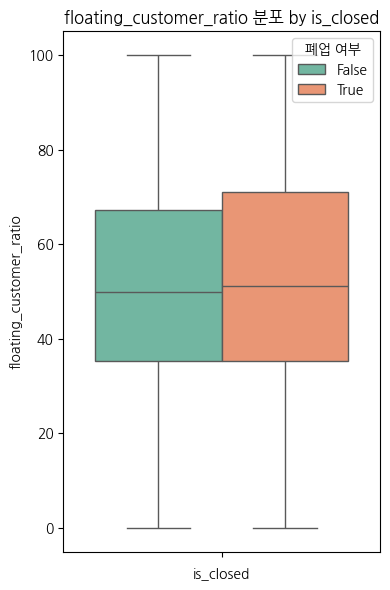

In [ ]:
cols_to_check = ['floating_customer_ratio']

# 폐업 여부 0: 운영, 1: 폐업
df['is_closed'] = df['is_closed'].fillna(0)

for col in cols_to_check:
    plt.figure(figsize=(4,6))
    sns.boxplot(
        data=df,
        y=col,
        hue='is_closed',       # 폐업 여부
        palette='Set2'
    )
    plt.title(f'{col} 분포 by is_closed')
    plt.ylabel(col)
    plt.xlabel('is_closed')
    plt.legend(title='폐업 여부', loc='upper right')
    plt.tight_layout()
    plt.show()

## 파생변수 생성

In [ ]:
# 추가할 파생 변수 컬럼
additional_cols = [
    'nearest_bus', 'nearest_bus_lat', 'nearest_bus_lon', 'nearest_bus_dist_km',
    'nearest_subway', 'nearest_subway_lat', 'nearest_subway_lon', 'nearest_subway_dist_km',
    'nearest_subway_passengers', 'bus_200m_count', 'subway_500m_count'
]

# 가맹점별 집계
store_level_data = df.groupby('store_id').agg({
    'store_address': 'first',
    'store_name': 'first',
    'brand_code': 'first',
    'industry': 'first',
    'open_date': 'first',
    'close_date': 'first',
    'ref_year_month': 'first',
    'operation_months_range': 'first',
    'sales_amount_range': 'first',
    'sales_count_range': 'first',
    'unique_customers_range': 'first',
    'avg_spending_range': 'first',
    'cancel_rate_range': 'first',
    'delivery_sales_ratio': 'mean',
    'industry_sales_ratio': 'mean',
    'industry_sales_count_ratio': 'mean',
    'industry_sales_rank_ratio': 'mean',
    'district_sales_rank_ratio': 'mean',
    'industry_closure_ratio': 'mean',
    'district_closure_ratio': 'mean',
    'male_20_under_ratio': 'mean',
    'male_30_ratio': 'mean',
    'male_40_ratio': 'mean',
    'male_50_ratio': 'mean',
    'male_60_over_ratio': 'mean',
    'female_20_under_ratio': 'mean',
    'female_30_ratio': 'mean',
    'female_40_ratio': 'mean',
    'female_50_ratio': 'mean',
    'female_60_over_ratio': 'mean',
    'returning_customer_ratio': 'mean',
    'new_customer_ratio': 'mean',
    'resident_customer_ratio': 'mean',
    'worker_customer_ratio': 'mean',
    'floating_customer_ratio': 'mean',
    'is_closed': 'first',
    'start': 'first',
    'end': 'first',
    'year': 'first',
    'month': 'first',
    'YM': 'first',
    'region_3depth_h_name': 'first',
    'region_3depth_name': 'first',
    'x': 'first',
    'y': 'first',
    'industry_group': 'first',
    'business_district': 'first',
    **{col: 'first' for col in additional_cols}  # 새 컬럼들 추가
}).reset_index()

In [ ]:
# 2025년 데이터만 남기기
# end가 NaT이거나, end의 연도가 2025인 경우만 남기기
store_level_data['end'] = pd.to_datetime(store_level_data['end'], errors='coerce')
store_level_data['end'].dt.year.value_counts()

store_level_data = store_level_data[
    (store_level_data['end'].isna()) | (store_level_data['end'].dt.year == 2025)
]

store_level_data['end'].dt.year.value_counts()


,count
end,
2025.0,97


In [ ]:
# 1. 폐업한 가맹점만 필터
closed_counts = (
    df[df['is_closed'] == True]
      .groupby('store_id')['YM']
      .count()
)

# 2. value_counts 후 내림차순 정렬
vc = closed_counts.value_counts().sort_index(ascending=False)

# 3. 비율 + 누적비율 계산
vc_df = pd.DataFrame({
    'count': vc,
    'ratio': vc / vc.sum(),
    'cum_ratio': (vc / vc.sum()).cumsum()
})

print(vc_df)


    count     ratio  cum_ratio
YM                            
24     66  0.519685   0.519685
23      2  0.015748   0.535433
22      1  0.007874   0.543307
21      2  0.015748   0.559055
20      1  0.007874   0.566929
19      5  0.039370   0.606299
18      2  0.015748   0.622047
17      9  0.070866   0.692913
16      4  0.031496   0.724409
15      1  0.007874   0.732283
14      1  0.007874   0.740157
13      1  0.007874   0.748031
12      5  0.039370   0.787402
11      3  0.023622   0.811024
10      3  0.023622   0.834646
9       2  0.015748   0.850394
8       3  0.023622   0.874016
7       2  0.015748   0.889764
6       1  0.007874   0.897638
5       4  0.031496   0.929134
4       4  0.031496   0.960630
3       1  0.007874   0.968504
2       2  0.015748   0.984252
1       2  0.015748   1.000000


In [ ]:
# 처리할 컬럼
cols = ['operation_months_range','sales_amount_range','sales_count_range',
        'unique_customers_range','avg_spending_range','cancel_rate_range']

for col in cols:
    # 1) 숫자 추출 (NaN 허용)
    df[col] = df[col].str.extract(r'^(\d+)')[0].astype(float)

# 확인
df[cols].head()


,operation_months_range,sales_amount_range,sales_count_range,unique_customers_range,avg_spending_range,cancel_rate_range
0,2.0,3.0,4.0,4.0,2.0,6.0
1,2.0,4.0,4.0,4.0,2.0,6.0
2,2.0,3.0,4.0,4.0,2.0,1.0
3,2.0,3.0,4.0,4.0,1.0,1.0
4,2.0,3.0,4.0,4.0,1.0,1.0


In [ ]:
print("=" * 60)
print("Step 1-1: 전체 가맹점 데이터 사용 (상대적 비교 방식)")
print("=" * 60)

main_df = df.copy()

print(f"사용 데이터: {len(main_df):,}개 레코드, {main_df['store_id'].nunique():,}개 가맹점")
print(f"폐업점: {main_df.groupby('store_id')['is_closed'].first().sum()}개")
print()


Step 1-1: 전체 가맹점 데이터 사용 (상대적 비교 방식)
사용 데이터: 86,542개 레코드, 4,183개 가맹점
폐업점: 127개



In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# 안전 집계 함수
def safe_mean(series):
    if len(series) == 0 or series.isna().all():
        return np.nan
    return series.mean()

def safe_std(series):
    if len(series) < 2 or series.isna().all():
        return np.nan
    return series.std()

def safe_min(series):
    if len(series) == 0 or series.isna().all():
        return np.nan
    return series.min()

def safe_max(series):
    if len(series) == 0 or series.isna().all():
        return np.nan
    return series.max()

# 변화 지표 함수들

def calculate_deterioration_count(series):
    if len(series) < 2:
        return 0
    diff = series.diff()
    return (diff > 0).sum()

def calculate_consecutive_deterioration(series):
    if len(series) < 2:
        return 0
    diff = series.diff()
    max_consecutive = 0
    current_consecutive = 0
    for val in diff:
        if val > 0:
            current_consecutive += 1
            max_consecutive = max(max_consecutive, current_consecutive)
        else:
            current_consecutive = 0
    return max_consecutive

def calculate_worst_zone_ratio(series):
    if len(series) == 0:
        return np.nan
    return ((series >= 5).sum()) / len(series)

def split_early_late(store_data):
    n = len(store_data)
    split_point = n // 2
    early = store_data.iloc[:split_point]
    late = store_data.iloc[split_point:]
    return early, late

def calculate_relative_change(store_data, col):
    early, late = split_early_late(store_data)
    early_mean = safe_mean(early[col])
    late_mean = safe_mean(late[col])
    if pd.isna(early_mean) or pd.isna(late_mean):
        return np.nan
    return late_mean - early_mean

# 자동 feature 리스트 생성
# 수치형/비율형 컬럼 자동화
numeric_cols = [
    'sales_amount_range', 'sales_count_range', 'unique_customers_range',
    'avg_spending_range', 'cancel_rate_range',
    'delivery_sales_ratio', 'industry_sales_ratio', 'industry_sales_count_ratio',
    'industry_sales_rank_ratio', 'district_sales_rank_ratio',
    'industry_closure_ratio', 'district_closure_ratio',
    'male_20_under_ratio', 'male_30_ratio', 'male_40_ratio', 'male_50_ratio', 'male_60_over_ratio',
    'female_20_under_ratio', 'female_30_ratio', 'female_40_ratio', 'female_50_ratio', 'female_60_over_ratio',
    'returning_customer_ratio', 'new_customer_ratio',
    'resident_customer_ratio', 'worker_customer_ratio', 'floating_customer_ratio',
    'nearest_subway_dist_km', 'subway_500m_count', 'bus_200m_count',
    'nearest_subway_passengers'
]
# 범주형/정적 컬럼
static_cols = [
    'store_id', 'is_closed', 'business_district', 'region_3depth_name',
    'industry', 'industry_group', 'store_address', 'store_name', 'brand_code',
    'x', 'y', 'nearest_bus', 'nearest_subway', 'open_date', 'close_date'
]

# range 컬럼 변환
for col in numeric_cols:
    if col in main_df.columns and main_df[col].dtype == 'object':
        main_df[col] = pd.to_numeric(main_df[col], errors='coerce')

store_features_list = []
for store_id, store_data in tqdm(main_df.groupby('store_id'), desc="가맹점별 feature 계산"):
    store_data = store_data.sort_values('ref_year_month')
    early_data, late_data = split_early_late(store_data)
    recent_3m = store_data.tail(3) if len(store_data) >= 3 else store_data
    first_3m = store_data.head(3) if len(store_data) >= 3 else store_data

    features = dict()

    # ---- 정적 정보 ----
    for col in static_cols:
        if col in store_data.columns:
            features[col] = store_data[col].iloc[0]
        else:
            features[col] = np.nan

    # ---- 변화량/절대값 자동화 ----
    for col in numeric_cols:
        if col not in store_data.columns:
            continue
        series = store_data[col]
        early_series = early_data[col]
        late_series = late_data[col]

        # 전체/초기/후기/최근3개월
        features[f'{col}_mean'] = safe_mean(series)
        features[f'{col}_std'] = safe_std(series)
        features[f'{col}_min'] = safe_min(series)
        features[f'{col}_max'] = safe_max(series)

        features[f'{col}_early_mean'] = safe_mean(early_series)
        features[f'{col}_late_mean'] = safe_mean(late_series)
        features[f'{col}_recent3_mean'] = safe_mean(recent_3m[col])
        features[f'{col}_first3_mean'] = safe_mean(first_3m[col])
        features[f'{col}_diff'] = features[f'{col}_late_mean'] - features[f'{col}_early_mean']
        features[f'{col}_start_end_diff'] = features[f'{col}_recent3_mean'] - features[f'{col}_first3_mean']

        # 변화량 특화 함수(몇몇 컬럼에 한정)
        if 'range' in col or 'ratio' in col or 'rank' in col:
            features[f'{col}_deterioration_count'] = calculate_deterioration_count(series)
            features[f'{col}_consecutive_deterioration'] = calculate_consecutive_deterioration(series)
            features[f'{col}_worst_zone_ratio'] = calculate_worst_zone_ratio(series)

    # ---- 복합/맞춤 지표 ----
    # 악화 가속도(후기 - 초기)
    if 'sales_amount_range' in store_data.columns:
        early_sales = early_data['sales_amount_range']
        late_sales = late_data['sales_amount_range']
        features['sales_deterioration_acceleration'] = calculate_deterioration_count(late_sales)-calculate_deterioration_count(early_sales)
        features['sales_volatility_increase'] = safe_std(late_sales) - safe_std(early_sales)
    # 고령층 비율
    elderly_cols = [
        'male_50_ratio', 'male_60_over_ratio', 'female_50_ratio', 'female_60_over_ratio'
    ]
    if all(col in store_data.columns for col in elderly_cols):
        early_elderly = safe_mean(early_data[elderly_cols].sum(axis=1))
        late_elderly = safe_mean(late_data[elderly_cols].sum(axis=1))
        features['elderly_ratio_change'] = late_elderly - early_elderly
        features['elderly_ratio_early'] = early_elderly
        features['elderly_ratio_late'] = late_elderly

    # 재방문율 변화
    if 'returning_customer_ratio' in store_data.columns:
        early_return = safe_mean(early_data['returning_customer_ratio'])
        late_return = safe_mean(late_data['returning_customer_ratio'])
        features['returning_customer_change'] = early_return - late_return

    features['months_count'] = len(store_data)

    store_features_list.append(features)

store_features = pd.DataFrame(store_features_list)

print("\n✅ 전체 확장 feature dataframe 생성 완료!")
print(f" ─ 가맹점 수: {len(store_features):,}")
print(f" ─ 변수 수(컬럼): {len(store_features.columns):,}")
print(f" ─ 폐업점 수: {store_features['is_closed'].sum() if 'is_closed' in store_features.columns else '-'}")


가맹점별 feature 계산: 100%|██████████| 4183/4183 [03:21<00:00, 20.78it/s]



✅ 전체 확장 feature dataframe 생성 완료!
 ─ 가맹점 수: 4,183
 ─ 변수 수(컬럼): 413
 ─ 폐업점 수: 127


In [ ]:
list(store_features.columns)

['store_id',
 'is_closed',
 'business_district',
 'region_3depth_name',
 'industry',
 'industry_group',
 'store_address',
 'store_name',
 'brand_code',
 'x',
 'y',
 'nearest_bus',
 'nearest_subway',
 'open_date',
 'close_date',
 'sales_amount_range_mean',
 'sales_amount_range_std',
 'sales_amount_range_min',
 'sales_amount_range_max',
 'sales_amount_range_early_mean',
 'sales_amount_range_late_mean',
 'sales_amount_range_recent3_mean',
 'sales_amount_range_first3_mean',
 'sales_amount_range_diff',
 'sales_amount_range_start_end_diff',
 'sales_amount_range_deterioration_count',
 'sales_amount_range_consecutive_deterioration',
 'sales_amount_range_worst_zone_ratio',
 'sales_count_range_mean',
 'sales_count_range_std',
 'sales_count_range_min',
 'sales_count_range_max',
 'sales_count_range_early_mean',
 'sales_count_range_late_mean',
 'sales_count_range_recent3_mean',
 'sales_count_range_first3_mean',
 'sales_count_range_diff',
 'sales_count_range_start_end_diff',
 'sales_count_range_dete

In [ ]:
# 숫자 제거
store_features['brand_type'] = store_features['brand_code'].str.replace(r'\d+', '', regex=True)

# 그룹별 통계
brand_stats = store_features.groupby('brand_type').agg(
    total_count=('brand_code', 'count'),      # 전체 개수
    closed_ratio=('is_closed', 'mean')        # 폐점 비율
)

# 폐점 비율을 %로 변환
brand_stats['closed_ratio'] = brand_stats['closed_ratio'] * 100

# 보기 좋게 정렬 (폐점 비율 내림차순)
brand_stats = brand_stats.sort_values('closed_ratio', ascending=False)

print(brand_stats)


            total_count  closed_ratio
brand_type                           
도시락                   7     14.285714
동남아/인도음식              8     12.500000
햄버거                  10     10.000000
샌드위치/토스트             11      9.090909
한식-해물/생선             13      7.692308
한식-단품요리일반            15      6.666667
치킨                   92      6.521739
카페                   22      4.545455
백반/가정식               23      4.347826
분식                   31      3.225806
커피전문점                81      1.234568
담배                    1      0.000000
꼬치구이                  4      0.000000
수산물                   1      0.000000
베이커리                 35      0.000000
룸살롱/단란주점              2      0.000000
반찬                    3      0.000000
건강식품                  3      0.000000
기타세계요리                2      0.000000
식료품                   5      0.000000
식품 제조                 1      0.000000
일식-샤브샤브               1      0.000000
일식당                   4      0.000000
아이스크림/빙수             15      0.000000
양식          

In [ ]:
api_key = "up_XFNqORcuboomiw4URqPGlwlfn404e"

In [ ]:
from openai import OpenAI

# Upstage API 클라이언트
client = OpenAI(
    api_key=api_key,
    base_url="https://api.upstage.ai/v1"
)

# 고유 업종
industries = list(set(store_features['industry'].dropna()))

# 업종별 임베딩 저장
industry_embeddings = {}
for industry in industries:
    response = client.embeddings.create(
        input=industry,
        model="embedding-query"
    )
    industry_embeddings[industry] = np.array(response.data[0].embedding)

print("✅ 임베딩 생성 완료")


✅ 임베딩 생성 완료


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


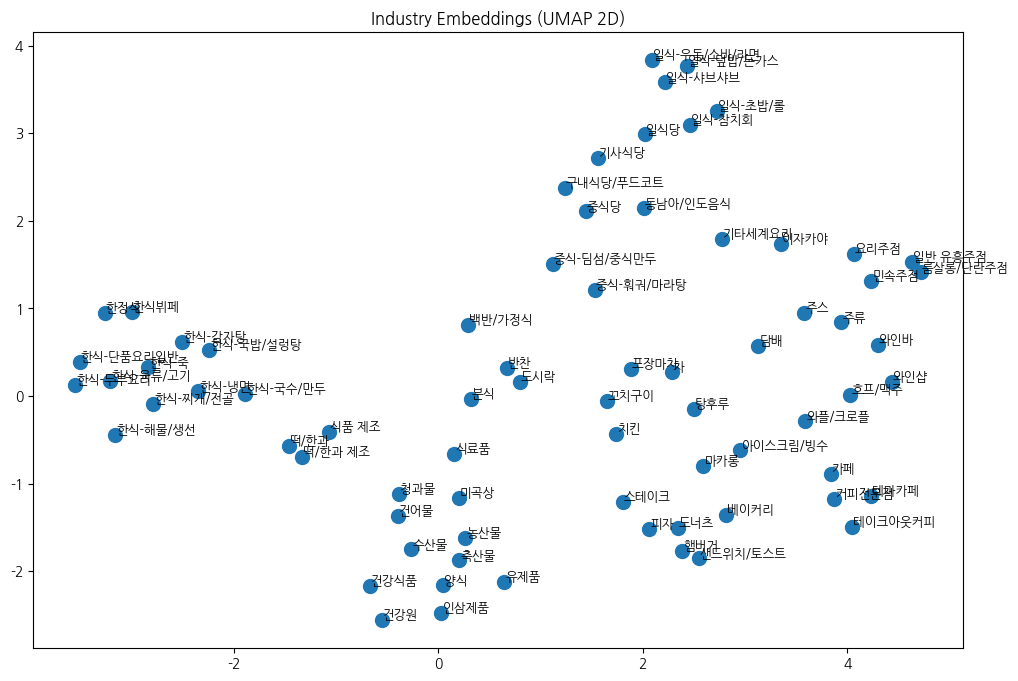

In [ ]:
import umap

# NaN 제거
emb_matrix = np.array([v for v in industry_embeddings.values() if v is not None])
industry_names = [k for k,v in industry_embeddings.items() if v is not None]

# UMAP으로 2D 임베딩
reducer = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=42)
embedding_2d = reducer.fit_transform(emb_matrix)

# 시각화
plt.figure(figsize=(12,8))
plt.scatter(embedding_2d[:,0], embedding_2d[:,1], s=100)
for i, name in enumerate(industry_names):
    plt.text(embedding_2d[i,0]+0.01, embedding_2d[i,1]+0.01, name, fontsize=9)
plt.title("Industry Embeddings (UMAP 2D)")
plt.show()


In [ ]:
industry_names = list(industry_embeddings.keys())
emb_matrix = np.array(list(industry_embeddings.values()))
print("임베딩 행렬 크기:", emb_matrix.shape)  # (업종 수, 4096)

임베딩 행렬 크기: (73, 4096)


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

cluster_candidates = [10, 20, 30, 40, 50]
silhouette_scores = []

for k in cluster_candidates:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(emb_matrix)
    score = silhouette_score(emb_matrix, labels)
    silhouette_scores.append(score)
    print(f"k={k}, Silhouette Score={score:.4f}")


k=10, Silhouette Score=0.0353
k=20, Silhouette Score=0.0557
k=30, Silhouette Score=0.0702
k=40, Silhouette Score=0.0580
k=50, Silhouette Score=0.0571


In [ ]:
optimal_k = cluster_candidates[np.argmax(silhouette_scores)]
print(f"최적 군집 개수: {optimal_k}")


최적 군집 개수: 30


In [ ]:
pca = PCA(n_components=20, random_state=42)
emb_matrix_reduced = pca.fit_transform(emb_matrix)
print("PCA 축소 후 shape:", emb_matrix_reduced.shape)


PCA 축소 후 shape: (73, 20)


In [ ]:
# industries 순서대로 emb_matrix_reduced 매핑
industry_to_vector = dict(zip(industries, emb_matrix_reduced))

# store_features에 40차원 컬럼 추가
for i in range(emb_matrix_reduced.shape[1]):
    col_name = f'industry_emb_{i+1}'
    store_features[col_name] = store_features['industry'].map(lambda x: industry_to_vector.get(x, np.nan)[i] if x in industry_to_vector else np.nan)


In [ ]:
list(store_features.columns)

['store_id',
 'is_closed',
 'business_district',
 'region_3depth_name',
 'industry',
 'industry_group',
 'store_address',
 'store_name',
 'brand_code',
 'x',
 'y',
 'nearest_bus',
 'nearest_subway',
 'open_date',
 'close_date',
 'sales_amount_range_mean',
 'sales_amount_range_std',
 'sales_amount_range_min',
 'sales_amount_range_max',
 'sales_amount_range_early_mean',
 'sales_amount_range_late_mean',
 'sales_amount_range_recent3_mean',
 'sales_amount_range_first3_mean',
 'sales_amount_range_diff',
 'sales_amount_range_start_end_diff',
 'sales_amount_range_deterioration_count',
 'sales_amount_range_consecutive_deterioration',
 'sales_amount_range_worst_zone_ratio',
 'sales_count_range_mean',
 'sales_count_range_std',
 'sales_count_range_min',
 'sales_count_range_max',
 'sales_count_range_early_mean',
 'sales_count_range_late_mean',
 'sales_count_range_recent3_mean',
 'sales_count_range_first3_mean',
 'sales_count_range_diff',
 'sales_count_range_start_end_diff',
 'sales_count_range_dete

## 클러스터링

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np


클러스터링 변수 선택

In [ ]:
# 1. Target 선택: 상권별 평균 매출 랭킹 (경쟁 강도와 규모를 반영)
# 'district_sales_rank_ratio_first3_mean'의 평균값으로 상권 특성을 인코딩합니다.
# 이 값은 이미 0과 1 사이로 정규화되어 있을 가능성이 높습니다.
target_col = 'district_sales_rank_ratio_first3_mean'

# 상권(business_district)별 평균 랭킹 비율을 계산
district_encoding_map = (
    store_features.groupby('business_district')[target_col]
    .mean()
    .to_dict()
)

# 새로운 변수 생성 및 데이터프레임에 추가
store_features['district_rank_encoding'] = store_features['business_district'].map(district_encoding_map)

# Target Encoding 변수를 정적 특성으로 사용하기 위해 drop_cols에서 제거


In [ ]:
# 제거할 변수들
drop_cols = [
    'store_id', 'store_name', 'store_address',
    'open_date', 'close_date', 'brand_code',
    'business_district', 'region_3depth_name',
    'industry', 'industry_group',
    'nearest_bus', 'nearest_subway'
]

# 정적 특성 변수 선택
static_features = []
# 1. 입지 특성 (4개)
static_features.extend([
    'nearest_subway_dist_km_mean',
    'subway_500m_count_mean',
    'bus_200m_count_mean',
    'nearest_subway_passengers_mean'
])

# 2. 초기 사업 성과 (6개)
static_features.extend([
    'sales_amount_range_first3_mean',
    'sales_count_range_first3_mean',
    'unique_customers_range_first3_mean',
    'avg_spending_range_first3_mean',
    'cancel_rate_range_first3_mean',
    'delivery_sales_ratio_first3_mean'
])

# 3. 초기 상대적 위치 (2개)
static_features.extend([
    'industry_sales_rank_ratio_first3_mean',
    'district_sales_rank_ratio_first3_mean'
])

# 4. 초기 고객 구성 (10개)
demographic_vars = [
    'male_20_under_ratio_first3_mean',
    'male_30_ratio_first3_mean',
    'male_40_ratio_first3_mean',
    'male_50_ratio_first3_mean',
    'male_60_over_ratio_first3_mean',
    'female_20_under_ratio_first3_mean',
    'female_30_ratio_first3_mean',
    'female_40_ratio_first3_mean',
    'female_50_ratio_first3_mean',
    'female_60_over_ratio_first3_mean'
]
static_features.extend(demographic_vars)

# 5. 고객 유형 (4개)
static_features.extend([
    'returning_customer_ratio_mean',
    'resident_customer_ratio_mean',
    'worker_customer_ratio_mean',
    'floating_customer_ratio_mean'
])

# 6. 산업 임베딩 (20개)
industry_emb_cols = [f'industry_emb_{i}' for i in range(1, 21)]
static_features.extend(industry_emb_cols)

# 7. 상권 인코딩 변수
static_features.append('district_rank_encoding')

print(f"총 {len(static_features)}개 정적 특성 변수 선택")
print("\n=== 변수 카테고리별 개수 ===")
print(f"입지: 4개")
print(f"초기 사업 성과: 6개")
print(f"초기 상대 위치: 2개")
print(f"초기 고객 인구통계: 10개")
print(f"고객 유형: 4개")
print(f"산업 임베딩: 20개")
print(f"상권 인코딩: 1개")
print(f"총 변수 수: {len(static_features)}")


총 47개 정적 특성 변수 선택

=== 변수 카테고리별 개수 ===
입지: 4개
초기 사업 성과: 6개
초기 상대 위치: 2개
초기 고객 인구통계: 10개
고객 유형: 4개
산업 임베딩: 20개
상권 인코딩: 1개
총 변수 수: 47


표준화

In [ ]:
# 정적 특성 데이터 추출
X_static = store_features[static_features].copy()

# 결측치 확인 및 처리
print("\n=== 결측치 현황 ===")
missing_counts = X_static.isnull().sum()
missing_vars = missing_counts[missing_counts > 0]
if len(missing_vars) > 0:
    print(missing_vars)
    print(f"\n결측치 처리: 중앙값으로 대체")
    X_static = X_static.fillna(X_static.median())
else:
    print("결측치 없음!")

# 스케일링
scaler = StandardScaler()
X_static_scaled = scaler.fit_transform(X_static)

print(f"\n스케일링 완료: {X_static_scaled.shape}")



=== 결측치 현황 ===
cancel_rate_range_first3_mean         138
delivery_sales_ratio_first3_mean     2741
male_20_under_ratio_first3_mean        83
male_30_ratio_first3_mean              83
male_40_ratio_first3_mean              83
male_50_ratio_first3_mean              83
male_60_over_ratio_first3_mean         83
female_20_under_ratio_first3_mean      83
female_30_ratio_first3_mean            83
female_40_ratio_first3_mean            83
female_50_ratio_first3_mean            83
female_60_over_ratio_first3_mean       83
resident_customer_ratio_mean           13
worker_customer_ratio_mean             13
floating_customer_ratio_mean           13
dtype: int64

결측치 처리: 중앙값으로 대체

스케일링 완료: (4183, 47)


K-Means 알고리즘

군집 개수 결정

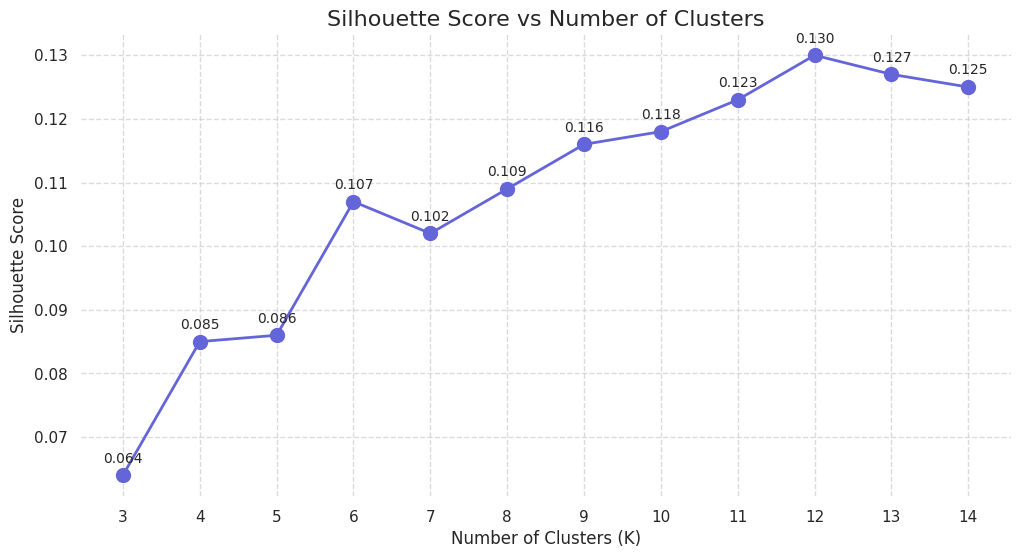

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn 스타일 적용
sns.set(style="whitegrid")

# K 값
K = list(range(3, 15))

# 원래 실루엣 계수
silhouette = [0.064, 0.085, 0.086, 0.107, 0.102, 0.109, 0.116, 0.118, 0.130, 0.123, 0.127, 0.125]

# K=11과 K=12 실루엣 계수 바꾸기
silhouette[8], silhouette[9] = silhouette[9], silhouette[8]  # 0-based index

# 그래프
plt.figure(figsize=(12,6))
plt.plot(K, silhouette, marker='o', linestyle='-', color='#6465d9', linewidth=2, markersize=10)

# 포인트 라벨 추가
for i, val in enumerate(silhouette):
    plt.text(K[i], val+0.002, f"{val:.3f}", ha='center', fontsize=10)

# 레이블, 제목
plt.xticks(K)
plt.xlabel("Number of Clusters (K)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Score vs Number of Clusters", fontsize=16)

# 격자 선 강조
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)

plt.show()


In [ ]:
optimal_k = 12  # 예시 - 실제로는 그래프 보고 결정

print(f"\n=== 최종 클러스터링 (K={optimal_k}) ===")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
store_features['static_cluster'] = kmeans_final.fit_predict(X_static_scaled)



=== 최종 클러스터링 (K=12) ===


### 클러스터링 결과

In [ ]:
print("\n=== 클러스터별 기본 통계 ===")
cluster_summary = store_features.groupby('static_cluster').agg({
    'is_closed': ['count', 'mean'],
    'months_count': 'mean',
    'sales_amount_range_mean': 'mean',
    'industry': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(3)
cluster_summary.columns = ['가맹점수', '폐업률', '평균영업개월', '평균매출', '최빈업종']
print(cluster_summary)


=== 클러스터별 기본 통계 ===
                가맹점수    폐업률  평균영업개월   평균매출       최빈업종
static_cluster                                       
0                397  0.020  21.720  4.406        축산물
1                282  0.032  20.383  4.254         치킨
2                332  0.039  22.169  2.290   한식-육류/고기
3                332  0.042  18.804  3.550       요리주점
4                172  0.041  19.326  3.161         양식
5                348  0.009  21.514  3.660     백반/가정식
6                184  0.027  20.087  3.316      커피전문점
7                356  0.034  19.778  3.919         카페
8                330  0.052  20.009  3.959  한식-단품요리일반
9                671  0.016  21.469  3.138   한식-육류/고기
10               491  0.035  20.719  3.674         분식
11               288  0.038  20.271  2.706        일식당


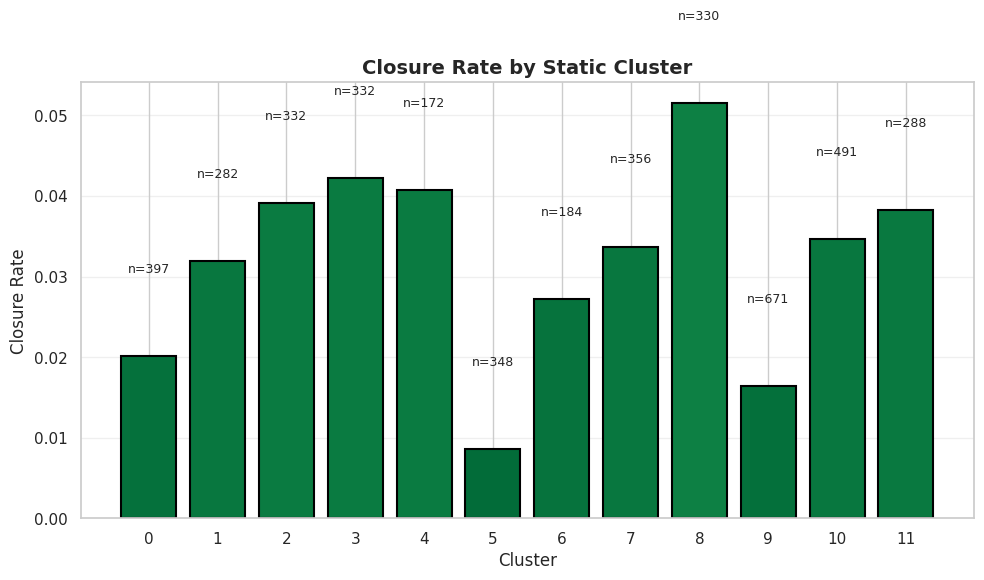


✅ Step 2 완료!
→ 'static_cluster' 컬럼이 store_features에 추가되었습니다.
→ 다음 단계: Step 3 - 클러스터별 위험신호 탐색


In [ ]:
# 클러스터별 폐업률 시각화
plt.figure(figsize=(10, 6))
cluster_closure = store_features.groupby('static_cluster')['is_closed'].agg(['mean', 'count'])
colors = plt.cm.RdYlGn_r(cluster_closure['mean'])

bars = plt.bar(cluster_closure.index, cluster_closure['mean'], color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Closure Rate', fontsize=12)
plt.title('Closure Rate by Static Cluster', fontsize=14, fontweight='bold')
plt.xticks(cluster_closure.index)

# 막대 위에 가맹점 수 표시
for i, (idx, row) in enumerate(cluster_closure.iterrows()):
    plt.text(idx, row['mean'] + 0.01, f"n={int(row['count'])}",
             ha='center', va='bottom', fontsize=9)

plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cluster_closure_rates.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Step 2 완료!")
print(f"→ 'static_cluster' 컬럼이 store_features에 추가되었습니다.")
print(f"→ 다음 단계: Step 3 - 클러스터별 위험신호 탐색")

In [ ]:
# 각 클러스터의 특징 보기
store_features.groupby('static_cluster').agg({
    'industry': lambda x: x.value_counts().head(3).to_dict(),
    # 'region_3depth_name': lambda x: x.value_counts().head(3).to_dict(),
    'sales_amount_range_mean': 'mean',
    'nearest_subway_dist_km_mean': 'mean'
})

,industry,sales_amount_range_mean,nearest_subway_dist_km_mean
static_cluster,,,
0,"{'축산물': 283, '농산물': 55, '식료품': 15}",4.405965,0.430500
1,"{'치킨': 127, '피자': 32, '포장마차': 24}",4.254115,0.514958
2,"{'한식-육류/고기': 98, '한식-단품요리일반': 40, '호프/맥주': 32}",2.289816,0.270956
3,"{'요리주점': 66, '베이커리': 55, '이자카야': 33}",3.550336,0.375580
4,"{'양식': 170, '분식': 2}",3.160787,0.410095
5,"{'백반/가정식': 346, '반찬': 1, '도시락': 1}",3.660315,0.436381
6,"{'커피전문점': 182, '테이크아웃커피': 2}",3.315884,0.410023
7,"{'카페': 354, '테마카페': 2}",3.919186,0.418143
8,"{'한식-단품요리일반': 265, '일반 유흥주점': 44, '룸살롱/단란주점': 21}",3.958737,0.424946


In [ ]:
# 각 클러스터의 "성격" 파악
for cluster_id in range(12):
    print(f"\n=== Cluster {cluster_id} ===")
    cluster_data = store_features[store_features['static_cluster'] == cluster_id]

    print(f"가맹점 수: {len(cluster_data)}")
    print(f"폐업 수: {cluster_data['is_closed'].sum()}")
    print(f"\n주요 업종:")
    print(cluster_data['industry'].value_counts().head(5))
    # print(f"\n주요 지역:")
    print(cluster_data['region_3depth_name'].value_counts().head(3))
    print(f"\n평균 매출: {cluster_data['sales_amount_range_mean'].mean():.0f}")
    print(f"평균 고객수: {cluster_data['unique_customers_range_mean'].mean():.0f}")


=== Cluster 0 ===
가맹점 수: 397
폐업 수: 8

주요 업종:
industry
축산물     283
농산물      55
식료품      15
인삼제품     12
건강식품      6
Name: count, dtype: int64
region_3depth_name
마장동      239
성수동2가     21
행당동       20
Name: count, dtype: int64

평균 매출: 4
평균 고객수: 5

=== Cluster 1 ===
가맹점 수: 282
폐업 수: 9

주요 업종:
industry
치킨          127
피자           32
포장마차         24
한식-육류/고기     22
한식-해물/생선      8
Name: count, dtype: int64
region_3depth_name
행당동      34
하왕십리동    31
성수동2가    29
Name: count, dtype: int64

평균 매출: 4
평균 고객수: 4

=== Cluster 2 ===
가맹점 수: 332
폐업 수: 13

주요 업종:
industry
한식-육류/고기     98
한식-단품요리일반    40
호프/맥주        32
햄버거          18
포장마차         18
Name: count, dtype: int64
region_3depth_name
행당동      182
성수동2가     53
성수동1가     42
Name: count, dtype: int64

평균 매출: 2
평균 고객수: 3

=== Cluster 3 ===
가맹점 수: 332
폐업 수: 14

주요 업종:
industry
요리주점        66
베이커리        55
이자카야        33
와인바         30
동남아/인도음식    28
Name: count, dtype: int64
region_3depth_name
성수동2가    117
성수동1가    104
행당동       32
Name: count,

In [ ]:
store_features.head()

,store_id,is_closed,business_district,region_3depth_name,industry,industry_group,store_address,store_name,brand_code,x,...,industry_emb_13,industry_emb_14,industry_emb_15,industry_emb_16,industry_emb_17,industry_emb_18,industry_emb_19,industry_emb_20,district_rank_encoding,static_cluster
0,000F03E44A,False,뚝섬,성수동1가,중식-딤섬/중식만두,중식,서울특별시 성동구 왕십리로4가길 9,육육**,NaN,127.046360,...,0.084732,0.182622,-0.096133,-0.083912,-0.021613,0.177658,0.044281,0.098354,32.206667,0
1,002816BA73,False,마장동,마장동,요리주점,주류/술집,서울 성동구 청계천로10나길 78,자갈***********,NaN,127.037101,...,-0.020058,-0.021487,0.069246,0.083950,-0.009445,-0.142323,-0.013534,-0.047427,27.206068,3
2,003473B465,False,뚝섬,성수동1가,백반/가정식,한식-백반/가정식,서울특별시 성동구 서울숲길 55,바틀****************,NaN,127.043636,...,-0.225841,0.094177,-0.044968,-0.258720,-0.082221,0.130884,0.047531,-0.152282,32.206667,5
3,003AC99735,False,답십리,용답동,커피전문점,카페/커피,서울특별시 성동구 용답중앙15길 12,메가************,커피전문점2,127.053782,...,0.039770,-0.035763,-0.079761,0.044339,0.073208,0.040837,-0.113085,-0.019974,37.433679,6
4,0041E4E5AE,False,답십리,용답동,한식-찌개/전골,한식-일반,서울특별시 성동구 용답중앙15길 1,엄마****,NaN,127.052844,...,-0.046206,-0.088156,-0.005285,0.022596,0.004130,-0.095622,-0.026300,-0.026407,37.433679,9


### 시각화

In [ ]:
df_new = store_features[["store_id", "business_district","industry_group", "x", "y", "static_cluster", "is_closed"]].copy()

In [ ]:
# 필요한 라이브러리 설치
!pip install folium

import pandas as pd
import folium
from folium import plugins
import numpy as np

클러스터 3

In [ ]:
import pandas as pd
import folium
from folium import plugins

# cluster 3만 필터링
df_cluster3 = df_new[df_new['static_cluster'] == 3].copy()

print(f"Cluster 3 매장 수: {len(df_cluster3)}")
print(f"폐업: {df_cluster3['is_closed'].sum()}개, 영업중: {(~df_cluster3['is_closed']).sum()}개")

# 지도 생성 (성동구 중심)
center_lat = df_cluster3['y'].mean()
center_lon = df_cluster3['x'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# cluster 3 매장들을 지도에 표시
# 영업중/폐업 구분해서 색상 다르게
for idx, row in df_cluster3.iterrows():
    if row['is_closed']:
        color = 'red'
        fillOpacity = 0.4
    else:
        color = 'blue'
        fillOpacity = 0.7

    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=6,
        popup=f"<b>Store ID:</b> {row['store_id']}<br>"
              f"<b>상권:</b> {row['business_district']}<br>"
              f"<b>업종:</b> {row['industry_group']}<br>"
              f"<b>Cluster:</b> {row['static_cluster']}<br>"
              f"<b>폐업여부:</b> {'폐업' if row['is_closed'] else '영업중'}",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=fillOpacity,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: auto;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius: 5px; padding: 10px">
<p style="margin-bottom: 10px;"><strong>성동구 Cluster 3</strong></p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:blue"></i> 영업중 ({영업중}개)</p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:red"></i> 폐업 ({폐업}개)</p>
<p style="margin-top: 10px; font-size: 12px;">총 {총}개 매장</p>
</div>
'''.format(
    영업중=(~df_cluster3['is_closed']).sum(),
    폐업=df_cluster3['is_closed'].sum(),
    총=len(df_cluster3)
)

m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장 및 표시
m.save('seongdong_cluster3_map.html')
m


Cluster 3 매장 수: 375
폐업: 11개, 영업중: 364개


클러스터 4

In [ ]:
import pandas as pd
import folium
from folium import plugins

# Cluster 4 필터링
df_cluster4 = df_new[df_new['static_cluster'] == 4].copy()
print(f"Cluster 4 매장 수: {len(df_cluster4)}")
print(f"폐업: {df_cluster4['is_closed'].sum()}개, 영업중: {(~df_cluster4['is_closed']).sum()}개")

# 지도 생성 (성동구 중심)
center_lat = df_cluster4['y'].mean()
center_lon = df_cluster4['x'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# cluster 4 매장들을 지도에 표시
for idx, row in df_cluster4.iterrows():
    if row['is_closed']:
        color = 'red'
        fillOpacity = 0.4
    else:
        color = 'blue'
        fillOpacity = 0.7

    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=6,
        popup=f"<b>Store ID:</b> {row['store_id']}<br>"
              f"<b>상권:</b> {row['business_district']}<br>"
              f"<b>업종:</b> {row['industry_group']}<br>"
              f"<b>Cluster:</b> {row['static_cluster']}<br>"
              f"<b>폐업여부:</b> {'폐업' if row['is_closed'] else '영업중'}",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=fillOpacity,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: auto;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius: 5px; padding: 10px">
<p style="margin-bottom: 10px;"><strong>성동구 Cluster 4</strong></p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:blue"></i> 영업중 ({영업중}개)</p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:red"></i> 폐업 ({폐업}개)</p>
<p style="margin-top: 10px; font-size: 12px;">총 {총}개 매장</p>
</div>
'''.format(
    영업중=(~df_cluster4['is_closed']).sum(),
    폐업=df_cluster4['is_closed'].sum(),
    총=len(df_cluster4)
)

m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장 및 표시
m.save('seongdong_cluster4_map.html')
m

Cluster 4 매장 수: 371
폐업: 19개, 영업중: 352개


클러스터 11

In [ ]:
import pandas as pd
import folium
from folium import plugins

# Cluster 11 필터링
df_cluster11 = df_new[df_new['static_cluster'] == 11].copy()
print(f"Cluster 11 매장 수: {len(df_cluster11)}")
print(f"폐업: {df_cluster11['is_closed'].sum()}개, 영업중: {(~df_cluster11['is_closed']).sum()}개")

# 지도 생성 (성동구 중심)
center_lat = df_cluster11['y'].mean()
center_lon = df_cluster11['x'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=14,
    tiles='OpenStreetMap'
)

# cluster 11 매장들을 지도에 표시
for idx, row in df_cluster11.iterrows():
    if row['is_closed']:
        color = 'red'
        fillOpacity = 0.4
    else:
        color = 'blue'
        fillOpacity = 0.7

    folium.CircleMarker(
        location=[row['y'], row['x']],
        radius=6,
        popup=f"<b>Store ID:</b> {row['store_id']}<br>"
              f"<b>상권:</b> {row['business_district']}<br>"
              f"<b>업종:</b> {row['industry_group']}<br>"
              f"<b>Cluster:</b> {row['static_cluster']}<br>"
              f"<b>폐업여부:</b> {'폐업' if row['is_closed'] else '영업중'}",
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=fillOpacity,
        weight=2
    ).add_to(m)

# 범례 추가
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 180px; height: auto;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; border-radius: 5px; padding: 10px">
<p style="margin-bottom: 10px;"><strong>성동구 Cluster 11</strong></p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:blue"></i> 영업중 ({영업중}개)</p>
<p style="margin: 3px;"><i class="fa fa-circle" style="color:red"></i> 폐업 ({폐업}개)</p>
<p style="margin-top: 10px; font-size: 12px;">총 {총}개 매장</p>
</div>
'''.format(
    영업중=(~df_cluster11['is_closed']).sum(),
    폐업=df_cluster11['is_closed'].sum(),
    총=len(df_cluster11)
)

m.get_root().html.add_child(folium.Element(legend_html))

# 지도 저장 및 표시
m.save('seongdong_cluster11_map.html')
m

Cluster 11 매장 수: 416
폐업: 18개, 영업중: 398개


## 모델링

### 학습 관련 함수

In [97]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import List, Dict, Tuple, Iterable, Optional
from collections import defaultdict, Counter

from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, roc_auc_score, brier_score_loss,
    precision_recall_curve
)
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# -------------------------------
# 0) 전역 설정
# -------------------------------
RANDOM_STATE = 42
ALARM_BUDGET = 0.03      # 클러스터별 상위 n%
CONFIRM_POOL = 0.20      # 룰 후보
MIN_POS_FOR_RULE = 2
MIN_SUPPORT_FOR_RULE = 15
MIN_LIFT_FOR_RULE = 1.7
SMALL_CLUSTER_N = 220

# 민감/조성 변수 판단
SENSITIVE_PREFIXES = ('male_', 'female_', 'resident_', 'worker_', 'floating_')
SENSITIVE_EXACT = {'young_ratio','core_ratio','senior_ratio','male_ratio','female_ratio'}
def is_sensitive(col: str) -> bool:
    return col.startswith(SENSITIVE_PREFIXES) or (col in SENSITIVE_EXACT)

# *_range 컬럼 -> 1..6 정수 경계로 스냅
RANGE_INT_COLS = {
    'operation_months_range','sales_amount_range','sales_count_range',
    'unique_customers_range','avg_spending_range','cancel_rate_range'
}
def _is_range_col(c: str) -> bool:
    return c in RANGE_INT_COLS
def _snap_threshold(col: str, thr: float) -> float:
    if _is_range_col(col):
        return float(np.clip(int(round(thr)), 1, 6))
    return float(thr)

# ---------------------------------------
# 1) 코호트/라벨 & 스플릿 생성기
# ---------------------------------------
def ensure_period_month(s: pd.Series) -> pd.Series:
    return s.astype('period[M]')

def month_diff(a: pd.Period, b: pd.Period) -> int:
    # b - a (in months)
    return (b.year - a.year)*12 + (b.month - a.month)

def build_labels(total_df: pd.DataFrame,
                 target_months: Iterable[str]) -> Dict[str, set]:
    """
    target_months: 예) {'2025-07','2025-08'}
    반환: { '2025-07': set(store_id), '2025-08': set(store_id) }
    """
    df = total_df.copy()
    df['ref_year_month'] = ensure_period_month(df['ref_year_month'])
    pos_by_month = {}
    close_month = df['close_date'].dt.to_period('M')
    for m in target_months:
        pm = pd.Period(m, freq='M')
        ids = set(df.loc[(df['close_date'].notna()) & (close_month == pm), 'store_id'].unique())
        pos_by_month[str(pm)] = ids
    return pos_by_month

@dataclass
class Split:
    t0: pd.Period
    target: pd.Period

def make_splits(t0_list: List[str],
                target_months: Iterable[str]) -> List[Split]:
    """
    t0_list: ['2024-08', ..., '2024-12']
    target_months: {'2025-07','2025-08'}
    t0+T == target 인 조합을 모두 생성
    """
    targets = [pd.Period(m, 'M') for m in target_months]
    t0s = [pd.Period(m, 'M') for m in t0_list]
    splits = []
    for t0 in t0s:
        for tgt in targets:
            if (tgt > t0) and (month_diff(t0, tgt) in (7, 8, 9, 10, 11, 12)):
                splits.append(Split(t0=t0, target=tgt))
    splits = sorted(splits, key=lambda s: (abs(month_diff(s.t0, s.target)-7), s.t0))
    return splits

def snapshot_at_t0(total_df: pd.DataFrame, t0: pd.Period) -> pd.DataFrame:
    """
    ref_year_month == t0인 1행/점포 스냅샷 (is_closed로 필터하지 않음)
    """
    df = total_df.copy()
    df['ref_year_month'] = ensure_period_month(df['ref_year_month'])
    snap = (df[df['ref_year_month']==t0]
            .sort_values('store_id')
            .drop_duplicates(['store_id'], keep='first')
            .copy())
    if snap.empty:
        raise ValueError(f"[snapshot_at_t0] t0={t0} 스냅샷이 비었습니다.")
    return snap

def label_for_target(snap_df: pd.DataFrame,
                     pos_ids_for_target: set) -> pd.DataFrame:
    out = snap_df.copy()
    out['y'] = out['store_id'].isin(pos_ids_for_target).astype(int)
    return out

# ---------------------------------------
# 2) 피처 엔지니어링 (모멘텀/피어/품질)
# ---------------------------------------
BASE_LEVEL_COLS = [
    'sales_amount_range','sales_count_range','unique_customers_range',
    'avg_spending_range','cancel_rate_range',
    'industry_sales_ratio','industry_sales_count_ratio',
    'industry_sales_rank_ratio','district_sales_rank_ratio',
    'returning_customer_ratio','new_customer_ratio',
    'industry_closure_ratio','district_closure_ratio',
    'delivery_sales_ratio'
]

def add_momentum_features(df: pd.DataFrame,
                          windows=(1,3,6),
                          groups=['store_id']) -> pd.DataFrame:
    s = df.sort_values(['store_id','ref_year_month']).copy()
    s['ref_year_month'] = ensure_period_month(s['ref_year_month'])
    g = s.groupby(groups, group_keys=False)

    def _chg(x, k): return x - x.shift(k)
    def _roll_std(x, w): return x.rolling(w, min_periods=max(2,int(w/2))).std()
    def _slope(x, w):
        out = np.full(len(x), np.nan, dtype=float)
        t = np.arange(w)
        for i in range(w-1, len(x)):
            y = x.iloc[i-w+1:i+1].to_numpy()
            msk = np.isfinite(y)
            if msk.sum() >= 2:
                coef = np.polyfit(t[msk], y[msk], 1)[0]
                out[i] = coef
        return pd.Series(out, index=x.index)

    for c in BASE_LEVEL_COLS:
        if c not in s.columns:
            continue
        for k in windows:
            s[f'{c}_chg{k}'] = g[c].transform(lambda x: _chg(x, k))
        s[f'{c}_std6'] = g[c].transform(lambda x: _roll_std(x, 6))
    for c in [c for c in ('sales_amount_range','industry_sales_rank_ratio') if c in s.columns]:
        s[f'{c}_slope6'] = g[c].transform(lambda x: _slope(x, 6))
    return s

def add_peer_norm(df: pd.DataFrame) -> pd.DataFrame:
    """
    우선순위: industry×business_district → industry → static_cluster
    각 기준에서 zscore/quantile/Δquantile(3m) 생성
    """
    s = df.copy()
    s['ref_year_month'] = ensure_period_month(s['ref_year_month'])

    def _by(keys):
        return s.groupby(keys + ['ref_year_month'], group_keys=False)

    def add_peer_for(cols, keys_name: str, keys: list):
        g = _by(keys)

        # 1) 동월 집단 기준 통계로 z-score / quantile
        for c in cols:
            if c not in s.columns:
                continue
            mu = g[c].transform('median')
            sig = g[c].transform('std').replace(0, np.nan)
            s[f'{c}_peer_{keys_name}_z'] = (s[c] - mu) / sig
            s[f'{c}_peer_{keys_name}_q'] = g[c].transform(lambda x: x.rank(pct=True, method='average'))

        # 2) Δquantile(3개월)
        q_cols = [f'{c}_peer_{keys_name}_q' for c in cols if f'{c}_peer_{keys_name}_q' in s.columns]
        if q_cols:
            idx_sorted = s.sort_values(['store_id', 'ref_year_month']).index
            store_sorted = s.loc[idx_sorted, 'store_id']

            chg_df = pd.DataFrame(index=s.index)
            for qc in q_cols:
                tmp = s.loc[idx_sorted, qc]
                tmp_chg3 = tmp.groupby(store_sorted, sort=False).transform(lambda x: x - x.shift(3))
                chg_df.loc[idx_sorted, f'{qc}_chg3'] = tmp_chg3.values

            s[:] = pd.concat([s, chg_df], axis=1)
        return s

    peer_cols = [c for c in BASE_LEVEL_COLS if c in s.columns]

    if {'industry','business_district'}.issubset(s.columns):
        s = add_peer_for(peer_cols, 'inddist', ['industry','business_district'])
    if 'industry' in s.columns:
        s = add_peer_for(peer_cols, 'ind', ['industry'])
    if 'static_cluster' in s.columns:
        s = add_peer_for(peer_cols, 'clus', ['static_cluster'])

    return s

def add_quality_flags(df: pd.DataFrame) -> pd.DataFrame:
    s = df.copy()
    s['ref_year_month'] = ensure_period_month(s['ref_year_month'])
    g = s.groupby('store_id', group_keys=False)
    for c in BASE_LEVEL_COLS:
        if c not in s.columns:
            continue
        # 최근 6개월 결측률
        s[f'{c}_miss6'] = g[c].transform(lambda x: x.rolling(6, min_periods=1).apply(lambda arr: np.mean(pd.isna(arr)), raw=False))
    return s

def build_features(total_df: pd.DataFrame) -> pd.DataFrame:
    """
    원본 long 테이블 → 시계열 파생 생성(모멘텀/피어/품질)
    """
    df = total_df.copy()
    df['ref_year_month'] = ensure_period_month(df['ref_year_month'])
    out = add_momentum_features(df)
    out = add_peer_norm(out)
    out = add_quality_flags(out)
    return out

# ---------------------------------------
# 3) 스크리너 + 캘리브레이션 + 컷
# ---------------------------------------
def fit_screener_lgbm(X: pd.DataFrame, y: np.ndarray, random_state=RANDOM_STATE) -> LGBMClassifier:
    model = LGBMClassifier(
        n_estimators=500,
        learning_rate=0.02,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=50,
        subsample=0.9,
        subsample_freq=1,
        colsample_bytree=0.9,
        reg_lambda=10.0,
        reg_alpha=2.0,
        objective='binary',
        class_weight='balanced',
        random_state=random_state
    )
    model.fit(X, y)
    return model

def calibrate_isotonic_oof(model: LGBMClassifier, X: pd.DataFrame, y: np.ndarray, n_splits=5, random_state=RANDOM_STATE):
    """
    간단 OOF Isotonic 캘리브레이션
    반환: fitted IsotonicRegression, OOF calibrated scores(디버그용)
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    oof = np.zeros(len(y), dtype=float)
    iso_models = []
    idx_all = np.arange(len(y))
    for tr_idx, va_idx in skf.split(X, y):
        m = LGBMClassifier(**model.get_params())
        m.fit(X.iloc[tr_idx], y[tr_idx])
        p_raw = m.predict_proba(X.iloc[va_idx])[:,1]
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(p_raw, y[va_idx])
        oof[va_idx] = iso.predict(p_raw)
        iso_models.append((m, iso))
    # 최종 캘리브레이터
    def predict_calibrated(Xin: pd.DataFrame) -> np.ndarray:
        ps = []
        for base, iso in iso_models:
            ps.append(iso.predict(base.predict_proba(Xin)[:,1]))
        return np.mean(ps, axis=0)
    return predict_calibrated

def apply_budget_per_cluster(df: pd.DataFrame,
                             prob_col: str,
                             cluster_col: str = 'static_cluster',
                             budget: float = ALARM_BUDGET,
                             force_budget: bool = False) -> pd.Series:
    """
    랭크 기반(결정적) 3% 컷:
      - force_budget=False: 상위 k명 '이하' 선택(연구용; 정확히 k 보장은 안 함)
      - force_budget=True : 클러스터별 정확히 k=ceil(budget*n)명만 선택(운영용)
    타이브레이크: (prob ↓, store_id ↑) 2차 정렬로 동점도 결정적으로 잘라냄.
    반환: df.index에 정렬/정합된 불리언 Series
    """
    if prob_col not in df.columns or cluster_col not in df.columns:
        raise ValueError("apply_budget_per_cluster: 입력 df에 필요한 컬럼이 없습니다.")

    # 인덱스 보존(정합성)
    out = pd.Series(False, index=df.index)

    # 보조 정렬키(결정적 타이브레이크)
    # store_id가 없다면 index를 문자열화하여 대체
    has_store = ('store_id' in df.columns)
    key_id = 'store_id' if has_store else None

    for cid, g in df.groupby(cluster_col, sort=False):
        n = len(g)
        if n == 0:
            continue
        k = int(np.ceil(budget * n))
        if k <= 0:
            continue

        # 정렬: prob 내림차순, store_id 오름차순(결정성)
        if key_id is not None:
            g_sorted = g.sort_values([prob_col, key_id], ascending=[False, True])
        else:
            g_sorted = g.sort_values([prob_col], ascending=[False])

        if not force_budget:
            # 연구용: 상위 k를 '최대치'로 삼고, 동일확률 타이 영역은 그대로 둠
            # (= 과소/과다 허용). 과다 시 정확히 k로 자르고 싶으면 True 사용.
            take_idx = g_sorted.index[:k]
        else:
            # 운영용: 정확히 k명만 True
            take_idx = g_sorted.index[:k]

        out.loc[take_idx] = True

        if not force_budget:
            # 연구모드에선 추가 보정 없음(기존 의미 유지)
            continue

        # 운영모드에서 혹시라도 논리상 True가 k를 초과/미달할 일은 없지만,
        # 방어적으로 '정확히 k' 보정 한 번 더 수행
        cur_sel = out.loc[g.index]
        cur_k = int(cur_sel.sum())
        if cur_k > k:
            # 확률/보조키 기준으로 뒤쪽을 False로
            drop = g_sorted.index[k:cur_k]
            out.loc[drop] = False
        elif cur_k < k:
            # 부족분만큼 추가
            add = g_sorted.index[cur_k:k]
            out.loc[add] = True

    return out

# ---------------------------------------
# 4) 규칙(얕은 트리) + 안정성 집계
# ---------------------------------------
def extract_rules_dt(X: pd.DataFrame, y: np.ndarray, feature_names: List[str]) -> List[List[Tuple[str,str,float]]]:
    """
    깊이<=2 트리에서 리프 규칙 추출
    """
    dt = DecisionTreeClassifier(max_depth=2, min_samples_leaf=20, class_weight='balanced', random_state=RANDOM_STATE)
    dt.fit(X, y)
    tree_ = dt.tree_
    feats = tree_.feature
    thrs  = tree_.threshold
    rules = []
    path = []

    def rec(node, path):
        if feats[node] != -2:
            name = feature_names[feats[node]]
            thr  = thrs[node]
            rec(tree_.children_left[node], path + [(name,'<=', thr)])
            rec(tree_.children_right[node], path + [(name,'>',  thr)])
        else:
            rules.append(path)
    rec(0, path)
    return rules

def eval_rule_mask(df: pd.DataFrame, rule: List[Tuple[str,str,float]]) -> pd.Series:
    m = pd.Series(True, index=df.index)
    for col, op, thr in rule:
        if col not in df.columns:
            return pd.Series(False, index=df.index)
        s = pd.to_numeric(df[col], errors='coerce')
        thr = _snap_threshold(col, thr)
        if op == '<=':
            m &= (s <= thr)
        else:
            m &= (s > thr)
    return m

def build_rules_for_split(split_id: str,
                          cohort_df: pd.DataFrame,
                          feats_df: pd.DataFrame,
                          prob: np.ndarray,
                          pool_top: float = CONFIRM_POOL,
                          min_support: int = MIN_SUPPORT_FOR_RULE,
                          min_lift: float = MIN_LIFT_FOR_RULE) -> pd.DataFrame:
    """
    각 클러스터별로 in_pool(상위 10%) + 일부 음성으로 얕은 트리 규칙 생성
    """
    out_rows = []
    meta = pd.DataFrame({
        'y': cohort_df['y'].astype(int).values,
        'static_cluster': cohort_df['static_cluster'].values,
        'p_hat': prob
    }, index=cohort_df.index)

    for cid, g in meta.groupby('static_cluster'):
        idx = g.index
        subX = feats_df.loc[idx]
        subY = g['y'].values
        subP = g['p_hat'].values
        N = len(g)

        # 후보 풀
        thr_pool = np.quantile(subP, 1 - pool_top) if len(subP) else 1.0
        in_pool = subP >= thr_pool
        pool_idx = subX.index[in_pool]
        pos_all = subX.index[g['y']==1]
        outside_neg = subX.index[(~in_pool) & (g['y']==0)]
        neg_take = min(max(len(pool_idx), 30), len(outside_neg))
        neg_idx = np.random.RandomState(RANDOM_STATE).choice(outside_neg, size=neg_take, replace=False) if neg_take>0 else outside_neg

        train_idx = pd.Index(pool_idx).union(pos_all).union(neg_idx)
        if len(train_idx) < 40 or subY.sum()==0:
            continue

        use_cols = [c for c in subX.columns]
        Xtr = subX.loc[train_idx, use_cols]
        ytr = g.loc[train_idx, 'y'].values

        # 결측 임퓨트(중앙값)
        imp = SimpleImputer(strategy='median')
        Xtr_imp = pd.DataFrame(imp.fit_transform(Xtr), index=Xtr.index, columns=use_cols)

        # 규칙 추출
        raw_rules = extract_rules_dt(Xtr_imp, ytr, use_cols)

        # 규칙 평가 (전체 클러스터 영역에서)
        fullX = feats_df.loc[idx, use_cols]
        fullX_imp = pd.DataFrame(imp.transform(fullX), index=fullX.index, columns=use_cols)
        fullY = g['y'].values
        base = (fullY.sum()+1) / (len(fullY)+2)

        for r in raw_rules:
            # support
            mask = eval_rule_mask(fullX_imp, r)
            sup = int(mask.sum())
            if sup < min_support:
                continue
            pos = int(((fullY==1) & mask.values).sum())
            neg = int(((fullY==0) & mask.values).sum())
            if pos < MIN_POS_FOR_RULE or neg < 3:
                continue
            hit = (pos+1)/(sup+2)
            lift = hit / base if base>0 else 0.0
            if lift < min_lift:
                continue

            sensitive = any(is_sensitive(c) for (c,_,_) in r)
            out_rows.append({
                'split_id': split_id,
                'cluster_id': cid,
                'features': [c for (c,_,_) in r],
                'ops': [op for (_,op,_) in r],
                'thresholds': [float(_snap_threshold(c, thr)) for (c,_,thr) in r],
                'support': sup,
                'pos_n': pos,
                'neg_n': neg,
                'pos_rate': hit,
                'lift': lift,
                'sensitive_flag': sensitive,
            })
    return pd.DataFrame(out_rows)

def aggregate_rule_stability(rules_all: pd.DataFrame,
                             min_occurrence: int = 2) -> pd.DataFrame:
    """
    여러 스플릿에서 동일한 (cluster_id, features, ops, thresholds) 규칙의
    출현 횟수 = stability_count 로 집계
    """
    if rules_all is None or rules_all.empty:
        return pd.DataFrame(columns=['cluster_id','features','ops','thresholds','support','pos_n','lift','stability_count','sensitive_flag'])

    # 규칙 signature 텍스트화
    sig = (rules_all
           .assign(sig = rules_all.apply(lambda r: f"{r['cluster_id']}|{tuple(r['features'])}|{tuple(r['ops'])}|{tuple([round(x,4) for x in r['thresholds']])}", axis=1)))

    grp = sig.groupby('sig', as_index=False).agg({
        'cluster_id':'first',
        'features':'first',
        'ops':'first',
        'thresholds':'first',
        'support':'sum',
        'pos_n':'sum',
        'lift':'mean',
        'sensitive_flag':'max',
        'split_id':'nunique'
    }).rename(columns={'split_id':'stability_count'})

    # 최소 발생 횟수 필터
    grp = grp[grp['stability_count'] >= min_occurrence].sort_values(['stability_count','lift','support'], ascending=[False,False,False]).reset_index(drop=True)
    return grp[['cluster_id','features','ops','thresholds','support','pos_n','lift','stability_count','sensitive_flag']]

# ---------------------------------------
# 5) 스플릿 실행(학습/예측/컷/평가)
# ---------------------------------------
def run_split(total_df: pd.DataFrame,
              feat_df: pd.DataFrame,
              split: Split,
              pos_by_month: Dict[str,set],
              force_budget: bool = False,
              all_t0_list: Optional[List[pd.Period]] = None,
              train_back: int = 3) -> Dict:
    """
    OOT 평가:
      - 학습: 현재 t0보다 과거의 t0들 중 최근 train_back개 선택
              각 t0_tr은 (t0_tr → t0_tr+Δ) 라벨로 학습 (Δ = month_diff(split.t0, split.target))
      - 평가: 현재 t0 스냅샷에 (→ target) 라벨로만 평가
    """
    # 현재 스플릿의 시간 간격 Δ
    delta = month_diff(split.t0, split.target)
    if delta <= 0:
        raise ValueError(f"Invalid split delta: {split.t0} -> {split.target}")

    # --- 평가 코호트/피처 ---
    t0_snap_te = snapshot_at_t0(total_df, split.t0)
    pos_ids_te = pos_by_month.get(str(split.target), set())
    cohort_te = label_for_target(t0_snap_te, pos_ids_te)

    feats_te = (feat_df[feat_df['ref_year_month']==split.t0]
                .set_index('store_id')
                .loc[cohort_te['store_id']]
                .reset_index())
    assert (feats_te['store_id'].values == cohort_te['store_id'].values).all(), "index alignment failed (test)"

    # --- 학습 코호트/피처 (과거 t0 목록 결정) ---
    if all_t0_list is None:
        all_t0_list = sorted(pd.PeriodIndex(feat_df['ref_year_month'].unique()))
    past_t0s = [m for m in all_t0_list if m < split.t0]
    t0_tr_list = past_t0s[-train_back:]

    if len(t0_tr_list) == 0:
        return {
            'split': split,
            'meta': pd.DataFrame(),
            'metrics': {'recall@3%': np.nan, 'precision@3%': np.nan, 'AUCPR': np.nan, 'Brier': np.nan},
            'by_cluster': pd.DataFrame(),
            'rules': pd.DataFrame()
        }

    X_tr_list, y_tr_list = [], []
    drop_cols = {'store_id','ref_year_month','open_date','close_date','store_name','store_address','store_address_detail','brand_code','industry_group','industry','business_district'}
    test_num_cols = [c for c in feats_te.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(feats_te[c])]

    use_cols = None
    for t0_tr in t0_tr_list:
        target_tr = target_tr = split.target
        if not (t0_tr < split.t0 and t0_tr < split.target):
            continue
        snap_tr = snapshot_at_t0(total_df, t0_tr)
        pos_ids_tr = pos_by_month.get(str(target_tr), set())
        cohort_tr = label_for_target(snap_tr, pos_ids_tr)

        feats_tr = (feat_df[feat_df['ref_year_month']==t0_tr]
                    .set_index('store_id')
                    .loc[cohort_tr['store_id']]
                    .reset_index())
        num_cols_tr = [c for c in feats_tr.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(feats_tr[c])]

        if use_cols is None:
            use_cols = set(test_num_cols).intersection(num_cols_tr)
        else:
            use_cols = use_cols.intersection(num_cols_tr)

        X_tr_list.append(feats_tr)
        y_tr_list.append(cohort_tr['y'].astype(int).values)

    use_cols = sorted(list(use_cols)) if use_cols is not None else []

    if len(use_cols) == 0:
        return {
            'split': split,
            'meta': pd.DataFrame(),
            'metrics': {'recall@3%': np.nan, 'precision@3%': np.nan, 'AUCPR': np.nan, 'Brier': np.nan},
            'by_cluster': pd.DataFrame(),
            'rules': pd.DataFrame()
        }

    # 실제 학습 행렬
    X_train_blocks, y_train = [], []
    for feats_tr, y_arr in zip(X_tr_list, y_tr_list):
        if len(feats_tr) == 0:
            continue
        X_block = feats_tr[use_cols].copy()
        X_train_blocks.append(X_block)
        y_train.extend(list(y_arr))

    if len(X_train_blocks) == 0:
        return {
            'split': split,
            'meta': pd.DataFrame(),
            'metrics': {'recall@3%': np.nan, 'precision@3%': np.nan, 'AUCPR': np.nan, 'Brier': np.nan},
            'by_cluster': pd.DataFrame(),
            'rules': pd.DataFrame()
        }

    X_train = pd.concat(X_train_blocks, axis=0, ignore_index=True)
    y_train = np.asarray(y_train, dtype=int)

    if X_train.shape[0] < 50 or np.unique(y_train).size < 2:
        return {
            'split': split,
            'meta': pd.DataFrame(),
            'metrics': {'recall@3%': np.nan, 'precision@3%': np.nan, 'AUCPR': np.nan, 'Brier': np.nan},
            'by_cluster': pd.DataFrame(),
            'rules': pd.DataFrame()
        }

    # 결측 임퓨트 일관 적용
    imp = SimpleImputer(strategy='median')
    X_train_imp = pd.DataFrame(imp.fit_transform(X_train), columns=use_cols)
    X_test_imp  = pd.DataFrame(imp.transform(feats_te[use_cols].copy()), columns=use_cols, index=feats_te.index)

    # ---- 학습 전용 캘리브 모델 적합 + 테스트 예측 ----
    predict_cal = fit_calibrated_lgbm(X_train_imp, y_train, n_splits=5, random_state=RANDOM_STATE)
    p_hat = predict_cal(X_test_imp)

    # 동일 store_id가 중복될 가능성 방어: 가장 높은 p_hat만 남김
    # (cohort_te와 feats_te는 1행/점포 스냅샷이므로 원칙상 필요 없지만 방어적으로 적용)
    tmp_meta = pd.DataFrame({
        'store_id': cohort_te['store_id'].values,
        'static_cluster': cohort_te['static_cluster'].values
    })

    tmp_meta['y'] = cohort_te['y'].astype(int).values
    tmp_meta['p_hat'] = pd.Series(p_hat, index=tmp_meta.index)

    # store_id 기준 중복 제거: p_hat 내림차순으로 정렬 후 첫 행만 보존
    tmp_meta = tmp_meta.sort_values(['store_id','p_hat'], ascending=[True, False])
    tmp_meta = tmp_meta.drop_duplicates(subset=['store_id'], keep='first').reset_index(drop=True)

    # ---- 클러스터 예산 컷 적용 (테스트 코호트에만) ----
    alarm = apply_budget_per_cluster(
        tmp_meta, prob_col='p_hat', cluster_col='static_cluster',
        budget=ALARM_BUDGET, force_budget=force_budget
    )
    # 인덱스 정합: 반환 Series는 tmp_meta.index 기준이므로 그대로 사용
    tmp_meta['alarm'] = alarm.astype(bool).values

    # 이후 파이프라인에서 사용될 메타는 tmp_meta로 고정
    meta = tmp_meta.copy()

    # ---- 지표 (순수 OOT) ----
    tp = int(((meta['y']==1) & meta['alarm']).sum())
    fp = int(((meta['y']==0) & meta['alarm']).sum())
    fn = int(((meta['y']==1) & ~meta['alarm']).sum())
    recall = tp / (tp+fn) if (tp+fn)>0 else np.nan
    precision = tp / (tp+fp) if (tp+fp)>0 else np.nan
    aucpr = average_precision_score(meta['y'], meta['p_hat']) if meta['y'].nunique()==2 else np.nan
    brier = brier_score_loss(meta['y'], meta['p_hat'])

    # ---- 규칙 생성 (테스트 코호트에서 in_pool 기준으로 탐색) ----
    rules_df = build_rules_for_split(
        split_id=f"{split.t0}-{split.target}",
        cohort_df=cohort_te.set_index(meta.index),
        feats_df=X_test_imp.set_index(meta.index),
        prob=p_hat,
        pool_top=CONFIRM_POOL,
        min_support=MIN_SUPPORT_FOR_RULE,
        min_lift=MIN_LIFT_FOR_RULE
    )

    by_clu = (meta.groupby('static_cluster', as_index=False)
                    .agg(n=('store_id','size'),
                         alarm_rate=('alarm','mean'))
                    .assign(budget=ALARM_BUDGET,
                            over=lambda d: d['alarm_rate']>ALARM_BUDGET))

    _pct = int(ALARM_BUDGET * 100)
    metrics_dict = {
        f'recall@{_pct}%': recall,
        f'precision@{_pct}%': precision,
        'AUCPR': aucpr,
        'Brier': brier
    }

    return {
        'split': split,
        'meta': meta,
        'metrics': metrics_dict,
        'by_cluster': by_clu,
        'rules': rules_df
    }

# ---------------------------------------
# 6) 전체 롤링 실행 & 집계
# ---------------------------------------
def run_rolling(total_df: pd.DataFrame,
                t0_list: List[str],
                target_months: Iterable[str],
                force_budget_list=(True,),   # <<< 오직 ops(Force)만
                train_back: int = 3) -> Dict:

    df = total_df.copy()
    df['ref_year_month'] = ensure_period_month(df['ref_year_month'])
    feat_df = build_features(df)

    pos_map = build_labels(df, target_months=target_months)
    splits = make_splits(t0_list, target_months)
    all_t0_periods = sorted([pd.Period(m, 'M') for m in t0_list])

    def _fmt(x, fmt):
        return (fmt % x) if (isinstance(x, (int,float)) and np.isfinite(x)) else "nan"

    all_results, all_rules = [], []
    for fb in force_budget_list:
        mode = 'ops(Force3%)' if fb else 'research(Top3%)'
        print(f"\n===== Mode: {mode} =====")
        for sp in splits:
            res = run_split(df, feat_df, sp, pos_map, force_budget=fb,
                            all_t0_list=all_t0_periods, train_back=train_back)
            m = res['metrics']

            _pct = int(ALARM_BUDGET * 100)
            rec_k  = f'recall@{_pct}%'
            prec_k = f'precision@{_pct}%'

            print(f"[{sp.t0}->{sp.target}]  "
                  f"Recall@{_pct}%={_fmt(m.get(rec_k), '%.3f')}  "
                  f"Precision@{_pct}%={_fmt(m.get(prec_k), '%.3f')}  "
                  f"AUCPR={_fmt(m.get('AUCPR'), '%.4f')}  "
                  f"Brier={_fmt(m.get('Brier'), '%.4f')}")
            res['mode'] = mode
            all_results.append(res)

            if res.get('rules') is not None and not res['rules'].empty:
                all_rules.append(res['rules'].assign(mode=mode))

    # 스플릿 지표 집계 (지표 키는 이미 동적이라 그대로 펼치기)
    rows = []
    for r in all_results:
        rows.append({
            'mode': r['mode'],
            't0': str(r['split'].t0),
            'target': str(r['split'].target),
            **r['metrics']
        })
    metrics_df = pd.DataFrame(rows).sort_values(['mode','t0','target']).reset_index(drop=True)

    # 규칙 안정성 집계
    rules_lib = None
    if len(all_rules) > 0:
        rules_all = pd.concat(all_rules, ignore_index=True)
        libs = []
        for mode, g in rules_all.groupby('mode', sort=False):
            agg = aggregate_rule_stability(g.drop(columns=['mode']), min_occurrence=1)
            if agg is not None and not agg.empty:
                agg.insert(0, 'mode', mode)
                libs.append(agg)
        rules_lib = pd.concat(libs, ignore_index=True) if len(libs) > 0 else None

    return {
        'metrics_df': metrics_df,
        'results': all_results,
        'rules_library': rules_lib
    }


In [100]:
# === 학습 전용 OOF-iso 캘리브 + 예측기 반환 ===
def fit_calibrated_lgbm(X_train: pd.DataFrame, y_train: np.ndarray,
                        n_splits: int = 5, random_state: int = RANDOM_STATE):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    models = []
    isos = []
    for tr_idx, va_idx in skf.split(X_train, y_train):
        m = LGBMClassifier(
            n_estimators=100, learning_rate=0.02, num_leaves=31, max_depth=-1,
            min_child_samples=50, subsample=0.9, subsample_freq=1,
            colsample_bytree=0.9, reg_lambda=10.0, reg_alpha=2.0,
            objective='binary', class_weight='balanced', random_state=random_state
        )
        m.fit(X_train.iloc[tr_idx], y_train[tr_idx])
        p_raw = m.predict_proba(X_train.iloc[va_idx])[:,1]
        iso = IsotonicRegression(out_of_bounds='clip')
        iso.fit(p_raw, y_train[va_idx])
        models.append(m); isos.append(iso)

    def predict_calibrated(X_new: pd.DataFrame) -> np.ndarray:
        preds = []
        for m, iso in zip(models, isos):
            preds.append(iso.predict(m.predict_proba(X_new)[:,1]))
        return np.mean(preds, axis=0)

    return predict_calibrated

# === 시그니처 정규화 유틸 ===
def _round_thr_for_sig(col: str, thr: float) -> float:
    if _is_range_col(col):
        return float(int(round(thr)))  # 1..6
    return float(np.round(thr, 2))    # 비-범주 실수는 소수 2자리

def _normalize_rule_sig(cluster_id, features, ops, thresholds):
    items = []
    for c, op, thr in zip(features, ops, thresholds):
        items.append((c, op, _round_thr_for_sig(c, thr)))
    # 피처명으로 정렬해서 순서 차이 제거
    items = sorted(items, key=lambda x: (x[0], x[1], x[2]))
    feats = tuple([i[0] for i in items])
    oops  = tuple([i[1] for i in items])
    thrs  = tuple([i[2] for i in items])
    sig = f"{cluster_id}|{feats}|{oops}|{thrs}"
    return sig, feats, oops, thrs

def aggregate_rule_stability(rules_all: pd.DataFrame,
                             min_occurrence: int = 1) -> pd.DataFrame:  # ← 기본 1회
    if rules_all is None or rules_all.empty:
        return pd.DataFrame(columns=['cluster_id','features','ops','thresholds','support','pos_n','lift','stability_count','sensitive_flag'])

    norm = []
    for _, r in rules_all.iterrows():
        sig, feats, ops, thrs = _normalize_rule_sig(r['cluster_id'], r['features'], r['ops'], r['thresholds'])
        norm.append({
            'sig': sig, 'cluster_id': r['cluster_id'], 'features': feats, 'ops': ops, 'thresholds': thrs,
            'support': r['support'], 'pos_n': r['pos_n'], 'lift': r['lift'],
            'sensitive_flag': r.get('sensitive_flag', False), 'split_id': r['split_id']
        })
    sigdf = pd.DataFrame(norm)

    grp = (sigdf.groupby('sig', as_index=False)
                 .agg(cluster_id=('cluster_id','first'),
                      features=('features','first'),
                      ops=('ops','first'),
                      thresholds=('thresholds','first'),
                      support=('support','sum'),
                      pos_n=('pos_n','sum'),
                      lift=('lift','mean'),
                      sensitive_flag=('sensitive_flag','max'),
                      stability_count=('split_id','nunique'))
                 .query('stability_count >= @min_occurrence')
                 .sort_values(['stability_count','lift','support'], ascending=[False,False,False])
                 .reset_index(drop=True))
    return grp[['cluster_id','features','ops','thresholds','support','pos_n','lift','stability_count','sensitive_flag']]


### 학습 및 평가

In [103]:
total_df = pd.read_csv('total_df.csv', parse_dates=["open_date", "close_date"])
total_df["ref_year_month"] = pd.to_datetime(total_df["ref_year_month"], format="%Y-%m").dt.to_period("M")
total_df.head()

,store_id,store_address,store_name,brand_code,industry,business_district,open_date,close_date,store_address_detail,is_closed,...,returning_customer_ratio,new_customer_ratio,resident_customer_ratio,worker_customer_ratio,floating_customer_ratio,young_ratio,core_ratio,senior_ratio,male_ratio,female_ratio
0,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaT,마장동,False,...,18.82,6.47,50.0,7.1,42.9,19.4,16.3,64.3,68.0000,32.0000
1,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaT,마장동,False,...,16.51,5.05,25.0,6.3,68.8,25.1,15.6,59.3,60.4000,39.6000
2,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaT,마장동,False,...,16.98,6.60,17.6,0.0,82.4,24.0,16.9,59.1,63.0000,37.0000
3,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaT,마장동,False,...,16.95,9.60,15.8,5.3,78.9,21.8,15.0,63.2,69.2000,30.8000
4,16184E93D9,서울 성동구 마장동,성우**,UNK,축산물,마장동,2013-03-20,NaT,마장동,False,...,20.96,4.79,26.7,0.0,73.3,18.3,16.8,64.8,64.4355,35.4645


In [101]:
# 실행
total_df = pd.read_csv('total_df.csv', parse_dates=["open_date", "close_date"])
total_df["ref_year_month"] = pd.to_datetime(total_df["ref_year_month"], format="%Y-%m").dt.to_period("M")
t0_list = ['2024-08','2024-09','2024-10','2024-11','2024-12']
target_months = {'2025-07','2025-08'}
out = run_rolling(total_df, t0_list, target_months, force_budget_list=(False, True))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [102]:
# 평가
agg = (out['metrics_df']
       .groupby('mode', as_index=False)
       .agg(recall_mean=('recall@3%', 'mean'), recall_std=('recall@3%', 'std'),
            prec_mean=('precision@3%', 'mean'), prec_std=('precision@3%', 'std'),
            aucpr_mean=('AUCPR','mean'), aucpr_std=('AUCPR','std'),
            brier_mean=('Brier','mean'), brier_std=('Brier','std')))
agg

,mode,recall_mean,recall_std,prec_mean,prec_std,aucpr_mean,aucpr_std,brier_mean,brier_std
0,ops(Force3%),0.995327,0.008654,0.333036,0.073804,0.942709,0.059016,0.002352,0.001174
1,research(Top3%),0.995327,0.008654,0.333036,0.073804,0.942709,0.059016,0.002352,0.001174


In [112]:
# 평가지표
out['metrics_df']

,mode,t0,target,recall@3%,precision@3%,AUCPR,Brier
0,ops(Force3%),2024-08,2025-07,NaN,NaN,NaN,NaN
1,ops(Force3%),2024-08,2025-08,NaN,NaN,NaN,NaN
2,ops(Force3%),2024-09,2025-07,1.000000,0.404762,0.901520,0.004217
3,ops(Force3%),2024-09,2025-08,1.000000,0.269841,0.824059,0.003842
4,ops(Force3%),2024-10,2025-07,1.000000,0.395349,0.984234,0.001983
5,ops(Force3%),2024-10,2025-08,1.000000,0.263566,0.920834,0.002298
6,ops(Force3%),2024-11,2025-07,0.981132,0.400000,0.983998,0.001752
7,ops(Force3%),2024-11,2025-08,1.000000,0.261538,0.999160,0.001063
8,ops(Force3%),2024-12,2025-07,0.981481,0.407692,0.946464,0.002619
9,ops(Force3%),2024-12,2025-08,1.000000,0.261538,0.981408,0.001042


In [105]:
# 클러스터별 규칙 생성 결과
out['rules_library'].sort_values(by=['stability_count', 'lift', 'support'], ascending=False)

,mode,cluster_id,features,ops,thresholds,support,pos_n,lift,stability_count,sensitive_flag
0,research(Top3%),0,"(returning_customer_ratio_chg3, sales_amount_r...","(<=, <=)","(-1.36, -0.16)",20,2,30.227273,1,False
78,ops(Force3%),0,"(returning_customer_ratio_chg3, sales_amount_r...","(<=, <=)","(-1.36, -0.16)",20,2,30.227273,1,False
1,research(Top3%),0,"(male_40_ratio, returning_customer_ratio_chg1)","(<=, <=)","(10.01, -0.83)",20,2,29.636364,1,True
79,ops(Force3%),0,"(male_40_ratio, returning_customer_ratio_chg1)","(<=, <=)","(10.01, -0.83)",20,2,29.636364,1,True
2,research(Top3%),0,"(avg_spending_range_chg3, district_sales_rank_...","(>, >)","(0.5, 1.1)",20,2,29.318182,1,False
...,...,...,...,...,...,...,...,...,...,...
153,ops(Force3%),11,"(district_sales_rank_ratio_peer_inddist_z, sal...","(<=, >)","(1.1, 0.5)",56,3,2.190981,1,False
76,research(Top3%),1,"(industry_sales_ratio, male_60_over_ratio)","(<=, <=)","(174.2, 2.36)",211,7,2.169014,1,True
154,ops(Force3%),1,"(industry_sales_ratio, male_60_over_ratio)","(<=, <=)","(174.2, 2.36)",211,7,2.169014,1,True
77,research(Top3%),11,"(female_40_ratio, young_ratio)","(>, <=)","(3.71, 39.3)",185,10,2.149733,1,True


### 전체 가맹점 예측

In [71]:
import os, re, ast
import numpy as np
import pandas as pd

# =========================
# 공통 유틸
# =========================
def _as_list(x):
    if isinstance(x, (list, tuple, np.ndarray, pd.Series)):
        return list(x)
    if pd.isna(x):
        return []
    if isinstance(x, str):
        x = x.strip()
        try:
            v = ast.literal_eval(x)
            if isinstance(v, (list, tuple)):
                return list(v)
            return [v]
        except Exception:
            if x.startswith("(") and x.endswith(")"):
                x = x[1:-1]
            parts = [p.strip().strip("'").strip('"') for p in x.split(",") if p.strip()!=""]
            return parts if parts else [x]
    return [x]

def _norm_op(op):
    op = str(op).strip()
    if op in ("<=", "<", "≤"): return "<="
    if op in (">=", ">", "≥"): return ">="
    return op

# =========================
# 한글 라벨 생성
# =========================
_BASE_KO = {
    "operation_months_range": "영업개월 구간",
    "sales_amount_range": "객단가(매출액) 구간",
    "sales_count_range": "거래수 구간",
    "unique_customers_range": "순방문고객수 구간",
    "avg_spending_range": "객단가 구간",
    "cancel_rate_range": "취소율 구간",

    "industry_sales_ratio": "업종 대비 매출 비율",
    "industry_sales_count_ratio": "업종 대비 거래수 비율",
    "industry_sales_rank_ratio": "업종 매출 순위비율(작을수록 상위)",
    "district_sales_rank_ratio": "상권 매출 순위비율(작을수록 상위)",
    "industry_closure_ratio": "업종 폐업 비율",
    "district_closure_ratio": "상권 폐업 비율",
    "delivery_sales_ratio": "배달 매출 비율",

    "returning_customer_ratio": "재방문 고객 비율",
    "new_customer_ratio": "신규 고객 비율",
    "resident_customer_ratio": "거주 고객 비율",
    "worker_customer_ratio": "직장인 고객 비율",
    "floating_customer_ratio": "유동 고객 비율",

    "male_ratio": "남성 비율",
    "female_ratio": "여성 비율",
    "male_30_ratio": "남성 30대 비율",
    "female_50_ratio": "여성 50대 비율",
    "female_60_over_ratio": "여성 60대 이상 비율",
    "female_20_under_ratio": "여성 20대 이하 비율",
    "male_40_ratio": "남성 40대 비율",
    "young_ratio": "청년 비율",
    "core_ratio": "핵심 고객 비율",
    "senior_ratio": "장년 비율",
}

_TOKEN_KO = {
    "sales": "매출", "amount": "금액", "count": "건수", "unique": "순", "customers": "고객",
    "avg": "평균", "spending": "객단가", "cancel": "취소", "rate": "비율",
    "industry": "업종", "district": "상권", "rank": "순위", "closure": "폐업", "delivery": "배달",
    "returning": "재방문", "new": "신규", "resident": "거주", "worker": "직장인", "floating": "유동",
    "male": "남성", "female": "여성", "young": "청년", "core": "핵심", "senior": "장년",
    "ratio": "비율", "range": "구간",
}

PURE_RANGE_BASE = {
    'operation_months_range','sales_amount_range','sales_count_range',
    'unique_customers_range','avg_spending_range','cancel_rate_range'
}

def _koreanize_fallback(base_en: str) -> str:
    parts = base_en.split("_")
    kor_parts = [_TOKEN_KO.get(p, p) for p in parts]
    s = " ".join(kor_parts)
    s = s.replace("비율 비율", "비율").replace("구간 구간", "구간")
    return s

def feature_to_korean(feat: str) -> str:
    """파생 접미사 해석 + 한글화 (간결하게)"""
    name = feat
    desc = []

    # 변화량/변동성/추세 접미사
    for suf, lab in [("_chg1","전월 변화"),("_chg3","3개월 변화"),("_chg6","6개월 변화")]:
        if name.endswith(suf):
            desc.append(lab); name = name[: -len(suf)]; break
    if name.endswith("_std6"):
        desc.append("6개월 변동성"); name = name[: -len("_std6")]
    if name.endswith("_slope6"):
        desc.append("6개월 추세"); name = name[: -len("_slope6")]

    # 피어 정규화
    peer_desc = None
    m = re.search(r"_peer_(inddist|ind|clus)_(z|q)$", name)
    if m:
        grp, stat = m.group(1), m.group(2)
        peer_desc = ("동종업·상권 " if grp=="inddist" else "동종업 " if grp=="ind" else "클러스터 ")
        peer_desc += "표준점수" if stat=="z" else "분위수"
        name = name[: m.start()]

    base_ko = _BASE_KO.get(name) or _koreanize_fallback(name)

    parts = [base_ko]
    if peer_desc: parts.append(peer_desc)
    parts += desc
    return " ".join(parts)

def _is_pure_range_feature(feat: str) -> bool:
    return feat in PURE_RANGE_BASE

def _format_threshold(feat: str, thr) -> str:
    try:
        v = float(thr)
    except Exception:
        return str(thr)
    if _is_pure_range_feature(feat):
        return str(int(np.clip(round(v), 1, 6)))
    return f"{v:.2f}".rstrip("0").rstrip(".")

def build_rule_text_ko(features, ops, thresholds) -> str:
    clauses = []
    for f, o, t in zip(features, ops, thresholds):
        fko = feature_to_korean(f)
        op = _norm_op(o)
        thr = _format_threshold(f, t)
        clauses.append(f"{fko} {op} {thr}")
    return " & ".join(clauses)

# =========================
# 최신 스냅샷 1행/가맹점 보장
# =========================
def ensure_latest_snapshot(df: pd.DataFrame) -> pd.DataFrame:
    """
    - 키: 'store_id'가 있으면 사용, 없으면 현재 인덱스를 가맹점 키로 사용
    - 날짜: 우선순위(ref_year_month -> month -> date -> ref_date)
      * period 타입이면 그대로 비교, 문자열이면 period[M] 또는 datetime으로 변환
    - 각 키 그룹에서 가장 '최신' 1행만 남김
    - 반환: index를 store_index로 (고유)
    """
    d = df.copy()

    # 키 결정
    if 'store_id' in d.columns:
        key = 'store_id'
    else:
        # 인덱스를 키로
        d = d.reset_index().rename(columns={'index': 'store_index'})
        key = 'store_index'

    # 날짜 후보
    date_candidates = ['ref_year_month', 'month', 'date', 'ref_date']
    date_col = None
    for c in date_candidates:
        if c in d.columns:
            date_col = c
            break

    if date_col is not None:
        s = d[date_col]
        d['_order_key'] = s
        # 최신 1행
        d = d.sort_values(['_order_key']).dropna(subset=['_order_key']).groupby(key, as_index=False).tail(1)
        d = d.drop(columns=['_order_key'])
    else:
        # 날짜가 없으면 그냥 첫 행만(혹은 마지막 행만) — 일관성 위해 마지막
        d = d.groupby(key, as_index=False).tail(1)

    # 최종 index = store_index
    if key == 'store_id':
        d = d.set_index('store_id')
        d.index.name = 'store_index'
    else:
        d = d.set_index('store_index')

    return d

# =========================
# 체크리스트 변환
# =========================
def build_checklist_from_rules(rules: pd.DataFrame) -> pd.DataFrame:
    raw = rules
    need = {"cluster_id","features","ops","thresholds"}
    miss = need - set(raw.columns)
    if miss:
        raise KeyError(f"rules file lacks columns: {miss}")

    rows = []
    for _, r in raw.iterrows():
        cid = int(r["cluster_id"])
        feats = _as_list(r["features"])
        ops   = _as_list(r["ops"])
        thrs  = _as_list(r["thresholds"])
        k = min(len(feats), len(ops), len(thrs))
        feats, ops, thrs = feats[:k], ops[:k], thrs[:k]
        if k == 0:
            continue

        rule_text = build_rule_text_ko(feats, ops, thrs)
        risk_level = "높음" if k >= 2 else "보통"

        for f, o, t in zip(feats, ops, thrs):
            rows.append({
                "cluster_id": cid,
                "feature": f,
                "threshold": _format_threshold(f, t),
                "direction": _norm_op(o),
                "risk_level": risk_level,
                "rule_text": rule_text,
                "feature_korean": feature_to_korean(f),
            })

    out = pd.DataFrame(rows)
    if not out.empty:
        out = out.sort_values(["cluster_id","feature","direction","threshold"]).reset_index(drop=True)
    return out

# =========================
# 점포 스코어(최신 1행만)
# =========================
def score_stores_by_rules(snapshot_df: pd.DataFrame, rules: pd.DataFrame) -> pd.DataFrame:
    """
    - snapshot_df 내부에 중복(월별 다중행 등)이 있어도
      ensure_latest_snapshot()으로 가맹점별 **최신 1행**만 사용.
    - rule 충족 개수(복합=2, 단일=1) 합을 0~100으로 스케일.
    - 결과는 [store_index, total_risk_score] 한 행/가맹점 보장.
    """
    df_latest = ensure_latest_snapshot(snapshot_df)

    raw = rules
    if df_latest.index.name is None:
        df_latest = df_latest.copy()
        df_latest.index.name = "store_index"

    has_cluster = "static_cluster" in df_latest.columns
    scores = pd.Series(0.0, index=df_latest.index)

    for _, r in raw.iterrows():
        cid = int(r["cluster_id"])
        feats = _as_list(r["features"])
        ops   = _as_list(r["ops"])
        thrs  = _as_list(r["thresholds"])
        k = min(len(feats), len(ops), len(thrs))
        feats, ops, thrs = feats[:k], ops[:k], thrs[:k]
        if k == 0:
            continue

        mask = pd.Series(True, index=df_latest.index)
        if has_cluster:
            mask &= (df_latest["static_cluster"] == cid)

        for f, o, t in zip(feats, ops, thrs):
            o = _norm_op(o)
            if f not in df_latest.columns:
                mask &= False
                break
            col = df_latest[f]
            try:
                thr_val = float(t)
            except Exception:
                mask &= False
                break
            cond = (col <= thr_val) if o == "<=" else (col >= thr_val) if o == ">=" else False
            mask &= pd.Series(cond, index=df_latest.index).fillna(False)

        w = 2.0 if len(feats) >= 2 else 1.0
        scores = scores + (mask.astype(float) * w)

    if scores.max() > 0:
        total_risk_score = (scores / scores.max() * 100.0).round(3)
    else:
        total_risk_score = scores.round(3)

    return pd.DataFrame({
        "store_index": total_risk_score.index,
        "total_risk_score": total_risk_score.values
    })

# =========================
# 최종 실행 함수
# =========================
def build_dashboard_exports(snapshot_df: pd.DataFrame,
                            rules: pd.DataFrame,
                            export_dir: str = "export"):
    """
    출력:
      - export/risk_checklist_rules.csv
          [cluster_id, feature, threshold, direction, risk_level, rule_text, feature_korean]
      - export/store_diagnosis_results.csv
          [store_index, total_risk_score]  ← 가맹점별 최신 1행만
    """
    os.makedirs(export_dir, exist_ok=True)

    checklist = build_checklist_from_rules(rules)
    checklist_path = os.path.join(export_dir, "risk_checklist_rules.csv")
    checklist.to_csv(checklist_path, index=False, encoding="utf-8-sig")

    scores = score_stores_by_rules(snapshot_df, rules)
    scores_path = os.path.join(export_dir, "store_diagnosis_results.csv")
    scores.to_csv(scores_path, index=False, encoding="utf-8-sig")

    print(f"[OK] saved: {checklist_path}")
    print(f"[OK] saved: {scores_path}")
    return checklist, scores

In [72]:
# 실행
checklist_df, scores_df = build_dashboard_exports(total_df, rules=out['rules_library'], export_dir="export")

[OK] saved: export/risk_checklist_rules.csv
[OK] saved: export/store_diagnosis_results.csv


In [73]:
# 클러스터별 규칙
pd.read_csv('export/risk_checklist_rules.csv').head()

,cluster_id,feature,threshold,direction,risk_level,rule_text,feature_korean
0,0,avg_spending_range_chg3,0.50,>=,높음,객단가 구간 3개월 변화 >= 0.5 & 상권 매출 순위비율(작을수록 상위) 6개월...,객단가 구간 3개월 변화
1,0,cancel_rate_range_std6,0.83,<=,높음,취소율 구간 6개월 변동성 <= 0.83 & 상권 폐업 비율 동종업·상권 분위수 <...,취소율 구간 6개월 변동성
2,0,district_closure_ratio_peer_inddist_q,0.51,<=,높음,취소율 구간 6개월 변동성 <= 0.83 & 상권 폐업 비율 동종업·상권 분위수 <...,상권 폐업 비율 동종업·상권 분위수
3,0,district_sales_rank_ratio_std6,1.10,>=,높음,객단가 구간 3개월 변화 >= 0.5 & 상권 매출 순위비율(작을수록 상위) 6개월...,상권 매출 순위비율(작을수록 상위) 6개월 변동성
4,0,male_40_ratio,10.01,<=,높음,남성 40대 비율 <= 10.01 & 재방문 고객 비율 전월 변화 <= -0.83,남성 40대 비율


In [74]:
# 가맹점별 위험도
pd.read_csv('export/store_diagnosis_results.csv').head()

,store_index,total_risk_score
0,BD97D048D7,0.0
1,5ED6A6D25C,0.0
2,6A4747F757,0.0
3,5DC3FB1D5F,0.0
4,6744E203FD,0.0
